In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import os
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [4]:
def get_mask_resized_num(targ,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(targ[1],targ[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [5]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [6]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [7]:
def random_jiggle_mask(all_mask,inteligent_random=True):
    min_y, min_x = np.argwhere(all_mask).min(axis=0)
    max_y, max_x = np.argwhere(all_mask).max(axis=0)
    dist_x = max_x-min_x
    dist_y = max_y-min_y
    avail_x = np.arange(0,all_mask.shape[1]-dist_x)
    avail_y = np.arange(0,all_mask.shape[0]-dist_y)
    
    #inteligent_random = True
    if inteligent_random==True:
        prob_x = np.ones(len(avail_x))
        prob_x[((avail_x>=min_x-dist_x)*(avail_x<=max_x))]=.001

        prob_y = np.ones(len(avail_y))
        prob_y[((avail_y>=min_y)*(avail_y<=max_y))]=.001

        choose_x = random.choices(avail_x,weights=prob_x,k=1)[0]
        choose_y = random.choices(avail_y,weights=prob_y,k=1)[0]
    else:        
        choose_x = random.choice(avail_x)
        choose_y = random.choice(avail_y)
    
    e_mask = np.zeros(all_mask.shape)
    blob = all_mask[min_y:max_y,min_x:max_x]
    e_mask[choose_y:choose_y+dist_y,choose_x:choose_x+dist_x] = blob
    return e_mask.astype(np.uint8)

In [8]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [9]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [10]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

(20, 499)
(0.8550100200400802, 8533)


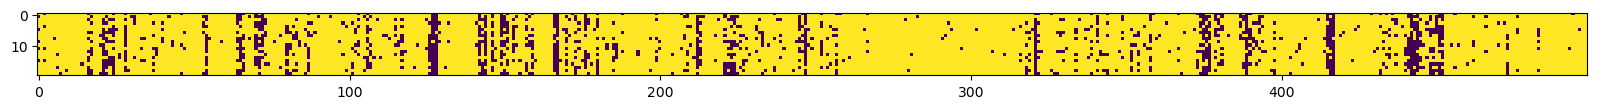

In [11]:
#good_videos = np.load('good_videos.npy')
good_videos = np.load('good_videos_1p.npy')
print(good_videos.shape)
print((good_videos.mean(),good_videos.sum()))
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

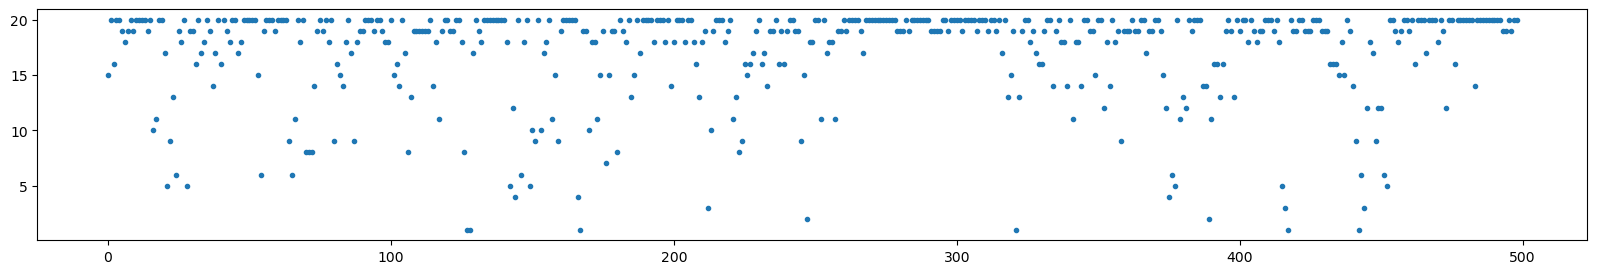

In [12]:
plt.figure(figsize=np.array((20,3)))
plt.plot(good_videos.sum(axis=0),'.')

In [13]:
good_videos[:,good_videos.sum(axis=0)<20] = False

In [14]:
# good_videos[:,good_videos.sum(axis=0)<15] = False
# good_videos[15:20,:] = False

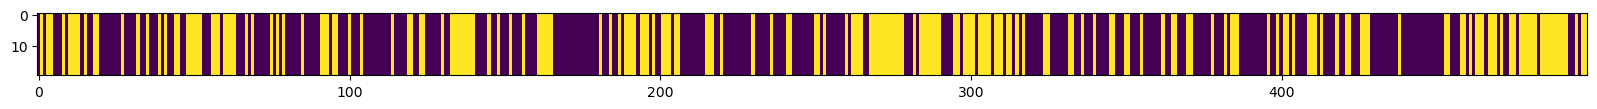

In [15]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

In [16]:
print(good_videos.mean(),good_videos.sum())

0.40681362725450904 4060


In [17]:
###

calc_or_load = 'load'

if calc_or_load=='calc':

    fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'
    pad_fn_temp = './Data/haa500_v1_1_resized/video/{folder}/{folder}_{video}_padding.npy'

    fns = []
    masks = []
    paddings = []

    for f in tqdm(range(good_videos.shape[1])):
        for v in range(good_videos.shape[0]):
            if bool(good_videos[v,f])==True:
                fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')

                mask = np.load(fn)
                mask = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
                mask = get_mask_resized_num((360, 640),mask)


                pad_fn = pad_fn_temp.format(folder=folders[f],video=f'{v:03d}')
                pad = np.load(pad_fn)

                fns.append(fn)
                masks.append(mask)
                paddings.append(pad)
                
                
    
    
    
    masks = np.array(masks)
    fns = np.array(fns)
    paddings = (np.array(paddings)==0)*1
    #paddings = np.array(paddings)
    
    np.savez_compressed('./Data/data_good_videos_1p_masks.npz',arr=masks)
    np.savez_compressed('./Data/data_good_videos_1p_fns.npz',arr=fns)
    np.savez_compressed('./Data/data_good_videos_1p_paddings.npz',arr=paddings)
    #np.savez_compressed('./Data/data_good_videos_1p.npz',masks=masks,fns=fns,paddings=paddings)
    
elif calc_or_load=='load':
    
    masks = np.load('./Data/data_good_videos_1p_masks.npz')['arr']
    fns = np.load('./Data/data_good_videos_1p_fns.npz')['arr']
    paddings = np.load('./Data/data_good_videos_1p_paddings.npz')['arr']
    
    #a = np.load('./Data/data_good_videos_1p.npz')
    ## TODO fix loading
    #masks = a['masks']
    #fns = a['fns']
    #paddings = a['paddings']
    #paddings = (paddings==0)*1

    #del a
    
    print(masks.shape)
    print(fns.shape)
    print(paddings.shape)

(4060, 360, 640)
(4060,)
(4060, 360, 640)


In [18]:
masks.shape

(4060, 360, 640)

In [19]:
paddings.shape

(4060, 360, 640)

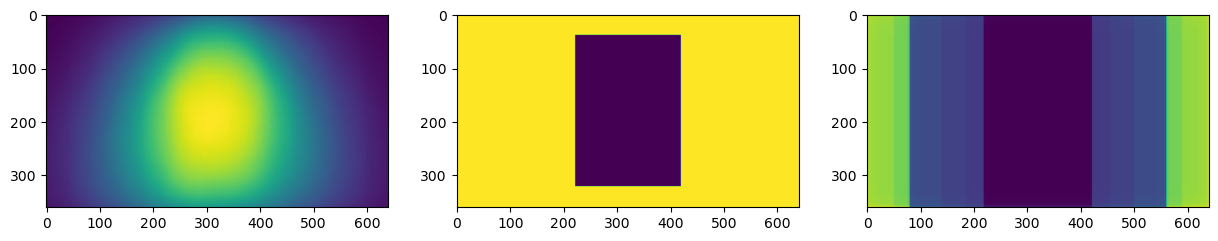

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(masks.mean(axis=0))
plt.subplot(1,3,2);plt.imshow(paddings.max(axis=0))
plt.subplot(1,3,3);plt.imshow(paddings.mean(axis=0))
#plt.show()

In [21]:
calc_or_load_inpaint_idx = 'calc'

if calc_or_load_inpaint_idx == 'calc':
    
    n = masks.shape[0]
    filled_spots = np.repeat(False,n)
    spots_found_for = np.repeat(False,n)
    where_to_inpaint_idx = np.zeros(n)
    masks_to_inpaint = np.zeros(masks.shape) # To keep the jiggled masks 

    plt.ioff()
    for i in tqdm(range(n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
            if np.mod(i,100)==0:
                np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
                np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
                np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
                np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)
    print('done')
    
elif calc_or_load_inpaint_idx == 'load':

    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
    masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']


    
#     a = np.load('./Data/data_inpainting_idx.npz')
#     filled_spots = a['filled_spots']
#     spots_found_for = a['spots_found_for']
#     where_to_inpaint_idx = a['where_to_inpaint_idx']
#     del a
    
#     print(filled_spots.shape)
#     print(spots_found_for.shape)
#     print(where_to_inpaint_idx.shape)
#     print(spots_found_for.sum())    

  0%|          | 0/4060 [00:00<?, ?it/s]

  0%|          | 1/4060 [00:03<4:27:15,  3.95s/it]

  0%|          | 2/4060 [00:07<4:24:14,  3.91s/it]

  0%|          | 3/4060 [00:11<4:25:55,  3.93s/it]

  0%|          | 4/4060 [00:15<4:20:51,  3.86s/it]

  0%|          | 5/4060 [00:19<4:19:32,  3.84s/it]

  0%|          | 6/4060 [00:23<4:19:45,  3.84s/it]

  0%|          | 7/4060 [00:27<4:20:56,  3.86s/it]

  0%|          | 8/4060 [00:31<4:22:20,  3.88s/it]

  0%|          | 9/4060 [00:34<4:21:47,  3.88s/it]

  0%|          | 10/4060 [00:38<4:24:18,  3.92s/it]

  0%|          | 11/4060 [00:42<4:25:34,  3.94s/it]

  0%|          | 12/4060 [00:46<4:25:27,  3.93s/it]

  0%|          | 13/4060 [00:50<4:24:53,  3.93s/it]

  0%|          | 14/4060 [00:54<4:30:25,  4.01s/it]

  0%|          | 15/4060 [00:58<4:27:24,  3.97s/it]

  0%|          | 16/4060 [01:02<4:24:51,  3.93s/it]

  0%|          | 17/4060 [01:06<4:26:26,  3.95s/it]

  0%|          | 18/4060 [01:10<4:27:31,  3.97s/it]

  0%|          | 19/4060 [01:36<11:48:27, 10.52s/it]

  0%|          | 20/4060 [01:40<9:38:30,  8.59s/it] 

  1%|          | 21/4060 [01:44<8:02:19,  7.17s/it]

  1%|          | 22/4060 [01:48<6:57:33,  6.20s/it]

  1%|          | 23/4060 [02:03<9:58:22,  8.89s/it]

  1%|          | 24/4060 [02:11<9:32:51,  8.52s/it]

  1%|          | 25/4060 [02:15<7:59:49,  7.14s/it]

  1%|          | 26/4060 [02:55<19:22:03, 17.28s/it]

  1%|          | 27/4060 [02:59<14:52:55, 13.28s/it]

  1%|          | 28/4060 [03:03<11:43:10, 10.46s/it]

  1%|          | 29/4060 [03:07<9:30:47,  8.50s/it] 

  1%|          | 30/4060 [03:11<7:58:49,  7.13s/it]

  1%|          | 31/4060 [03:15<6:54:20,  6.17s/it]

  1%|          | 32/4060 [03:19<6:08:55,  5.50s/it]

  1%|          | 33/4060 [03:23<5:40:12,  5.07s/it]

  1%|          | 34/4060 [03:42<10:08:28,  9.07s/it]

  1%|          | 35/4060 [04:51<30:21:38, 27.15s/it]

  1%|          | 36/4060 [04:55<22:33:01, 20.17s/it]

  1%|          | 37/4060 [05:24<25:38:19, 22.94s/it]

  1%|          | 38/4060 [05:28<19:14:06, 17.22s/it]

  1%|          | 39/4060 [05:32<14:44:56, 13.20s/it]

  1%|          | 40/4060 [05:36<11:43:24, 10.50s/it]

  1%|          | 41/4060 [05:40<9:31:59,  8.54s/it] 

  1%|          | 42/4060 [08:13<57:46:45, 51.77s/it]

  1%|          | 43/4060 [08:17<41:55:38, 37.57s/it]

  1%|          | 44/4060 [11:09<86:51:48, 77.87s/it]

  1%|          | 45/4060 [14:06<119:53:59, 107.51s/it]

  1%|          | 46/4060 [17:02<142:46:31, 128.05s/it]

  1%|          | 47/4060 [17:15<104:30:18, 93.75s/it] 

  1%|          | 48/4060 [17:22<75:27:09, 67.70s/it] 

  1%|          | 49/4060 [18:29<75:04:27, 67.38s/it]

  1%|          | 50/4060 [18:39<55:51:47, 50.15s/it]

  1%|▏         | 51/4060 [21:32<96:51:15, 86.97s/it]

  1%|▏         | 52/4060 [24:29<127:06:35, 114.17s/it]

  1%|▏         | 53/4060 [27:20<145:57:09, 131.13s/it]

  1%|▏         | 54/4060 [27:24<103:21:47, 92.89s/it] 

  1%|▏         | 55/4060 [27:28<73:36:04, 66.16s/it] 

  1%|▏         | 56/4060 [27:31<52:42:03, 47.38s/it]

  1%|▏         | 57/4060 [27:35<38:04:18, 34.24s/it]

  1%|▏         | 58/4060 [28:58<54:27:39, 48.99s/it]

  1%|▏         | 59/4060 [29:02<39:19:52, 35.39s/it]

  1%|▏         | 60/4060 [29:05<28:44:24, 25.87s/it]

  2%|▏         | 61/4060 [29:09<21:26:48, 19.31s/it]

  2%|▏         | 62/4060 [29:13<16:16:36, 14.66s/it]

  2%|▏         | 63/4060 [29:27<16:09:10, 14.55s/it]

  2%|▏         | 64/4060 [29:31<12:32:50, 11.30s/it]

  2%|▏         | 65/4060 [29:35<10:08:47,  9.14s/it]

  2%|▏         | 66/4060 [29:39<8:28:21,  7.64s/it] 

  2%|▏         | 67/4060 [29:43<7:10:03,  6.46s/it]

  2%|▏         | 68/4060 [29:47<6:20:14,  5.72s/it]

  2%|▏         | 69/4060 [29:53<6:18:37,  5.69s/it]

  2%|▏         | 70/4060 [29:57<5:43:41,  5.17s/it]

  2%|▏         | 71/4060 [30:01<5:19:16,  4.80s/it]

  2%|▏         | 72/4060 [30:05<5:04:29,  4.58s/it]

  2%|▏         | 73/4060 [30:09<4:50:06,  4.37s/it]

  2%|▏         | 74/4060 [30:13<4:44:29,  4.28s/it]

  2%|▏         | 75/4060 [30:16<4:32:35,  4.10s/it]

  2%|▏         | 76/4060 [30:20<4:24:51,  3.99s/it]

  2%|▏         | 77/4060 [30:26<4:54:12,  4.43s/it]

  2%|▏         | 78/4060 [30:29<4:39:48,  4.22s/it]

  2%|▏         | 79/4060 [30:33<4:30:04,  4.07s/it]

  2%|▏         | 80/4060 [30:37<4:23:00,  3.96s/it]

  2%|▏         | 81/4060 [31:15<15:39:06, 14.16s/it]

  2%|▏         | 82/4060 [31:22<13:22:15, 12.10s/it]

  2%|▏         | 83/4060 [31:26<10:41:17,  9.68s/it]

  2%|▏         | 84/4060 [31:30<8:47:39,  7.96s/it] 

  2%|▏         | 85/4060 [33:22<43:12:23, 39.13s/it]

  2%|▏         | 86/4060 [33:26<31:31:50, 28.56s/it]

  2%|▏         | 87/4060 [33:30<23:23:05, 21.19s/it]

  2%|▏         | 88/4060 [33:33<17:34:54, 15.94s/it]

  2%|▏         | 89/4060 [33:37<13:33:13, 12.29s/it]

  2%|▏         | 90/4060 [33:41<10:44:07,  9.73s/it]

  2%|▏         | 91/4060 [33:45<8:49:17,  8.00s/it] 

  2%|▏         | 92/4060 [33:55<9:40:26,  8.78s/it]

  2%|▏         | 93/4060 [33:59<7:59:06,  7.25s/it]

  2%|▏         | 94/4060 [34:03<6:50:11,  6.21s/it]

  2%|▏         | 95/4060 [34:07<5:59:58,  5.45s/it]

  2%|▏         | 96/4060 [34:10<5:25:40,  4.93s/it]

  2%|▏         | 97/4060 [34:21<7:12:33,  6.55s/it]

  2%|▏         | 98/4060 [37:10<60:51:49, 55.30s/it]

  2%|▏         | 99/4060 [38:07<61:35:59, 55.99s/it]

  2%|▏         | 100/4060 [38:11<44:19:59, 40.30s/it]

  2%|▏         | 101/4060 [1:03:50<538:39:12, 489.81s/it]

  3%|▎         | 102/4060 [1:03:53<378:05:03, 343.89s/it]

  3%|▎         | 103/4060 [1:03:56<265:41:37, 241.72s/it]

  3%|▎         | 104/4060 [1:06:33<237:38:52, 216.26s/it]

  3%|▎         | 105/4060 [1:06:37<167:24:38, 152.38s/it]

  3%|▎         | 106/4060 [1:06:40<118:15:02, 107.66s/it]

  3%|▎         | 107/4060 [1:06:43<83:52:59, 76.39s/it]  

  3%|▎         | 108/4060 [1:09:38<116:15:59, 105.91s/it]

  3%|▎         | 109/4060 [1:10:49<104:39:23, 95.36s/it] 

  3%|▎         | 110/4060 [1:10:54<74:58:50, 68.34s/it] 

  3%|▎         | 111/4060 [1:10:58<53:50:18, 49.08s/it]

  3%|▎         | 112/4060 [1:11:02<38:58:06, 35.53s/it]

  3%|▎         | 113/4060 [1:11:06<28:34:04, 26.06s/it]

  3%|▎         | 114/4060 [1:11:14<22:30:24, 20.53s/it]

  3%|▎         | 115/4060 [1:14:21<77:09:11, 70.41s/it]

  3%|▎         | 116/4060 [1:17:28<115:32:02, 105.46s/it]

  3%|▎         | 117/4060 [1:17:35<83:22:30, 76.12s/it]  

  3%|▎         | 118/4060 [1:17:40<59:41:21, 54.51s/it]

  3%|▎         | 119/4060 [1:17:43<43:02:20, 39.32s/it]

  3%|▎         | 120/4060 [1:17:47<31:24:41, 28.70s/it]

  3%|▎         | 121/4060 [1:17:51<23:12:56, 21.22s/it]

  3%|▎         | 122/4060 [1:17:55<17:31:04, 16.01s/it]

  3%|▎         | 123/4060 [1:17:59<13:30:57, 12.36s/it]

  3%|▎         | 124/4060 [1:20:52<66:16:50, 60.62s/it]

  3%|▎         | 125/4060 [1:23:45<102:57:37, 94.19s/it]

  3%|▎         | 126/4060 [1:23:48<73:15:45, 67.04s/it] 

  3%|▎         | 127/4060 [1:23:52<52:28:28, 48.03s/it]

  3%|▎         | 128/4060 [1:24:03<40:11:34, 36.80s/it]

  3%|▎         | 129/4060 [1:24:06<29:19:29, 26.86s/it]

  3%|▎         | 130/4060 [1:26:59<77:10:11, 70.69s/it]

  3%|▎         | 131/4060 [1:28:51<90:37:59, 83.04s/it]

  3%|▎         | 132/4060 [1:29:02<67:03:23, 61.46s/it]

  3%|▎         | 133/4060 [1:31:48<101:19:07, 92.88s/it]

  3%|▎         | 134/4060 [1:31:52<72:09:05, 66.16s/it] 

  3%|▎         | 135/4060 [1:31:56<51:37:55, 47.36s/it]

  3%|▎         | 136/4060 [1:31:59<37:18:57, 34.23s/it]

  3%|▎         | 137/4060 [1:32:03<27:20:32, 25.09s/it]

  3%|▎         | 138/4060 [1:34:51<74:02:35, 67.96s/it]

  3%|▎         | 139/4060 [1:37:38<106:31:56, 97.81s/it]

  3%|▎         | 140/4060 [1:37:43<75:55:00, 69.72s/it] 

  3%|▎         | 141/4060 [1:37:46<54:20:36, 49.92s/it]

  3%|▎         | 142/4060 [1:38:07<44:39:49, 41.04s/it]

  4%|▎         | 143/4060 [1:38:14<33:30:08, 30.79s/it]

  4%|▎         | 144/4060 [1:38:20<25:41:29, 23.62s/it]

  4%|▎         | 145/4060 [1:41:08<72:42:15, 66.85s/it]

  4%|▎         | 146/4060 [1:41:15<53:07:28, 48.86s/it]

  4%|▎         | 147/4060 [1:43:55<89:20:19, 82.19s/it]

  4%|▎         | 148/4060 [1:46:49<119:05:38, 109.60s/it]

  4%|▎         | 149/4060 [1:46:52<84:32:59, 77.83s/it]  

  4%|▎         | 150/4060 [1:46:56<60:24:47, 55.62s/it]

  4%|▎         | 151/4060 [1:47:00<43:31:30, 40.08s/it]

  4%|▎         | 152/4060 [1:47:28<39:46:24, 36.64s/it]

  4%|▍         | 153/4060 [1:47:32<29:02:53, 26.77s/it]

  4%|▍         | 154/4060 [1:47:36<21:31:04, 19.83s/it]

  4%|▍         | 155/4060 [1:47:53<20:38:22, 19.03s/it]

  4%|▍         | 156/4060 [1:47:57<15:49:24, 14.59s/it]

  4%|▍         | 157/4060 [1:48:04<13:13:17, 12.20s/it]

  4%|▍         | 158/4060 [1:48:07<10:21:11,  9.55s/it]

  4%|▍         | 159/4060 [1:48:11<8:19:46,  7.69s/it] 

  4%|▍         | 160/4060 [1:48:14<6:54:38,  6.38s/it]

  4%|▍         | 161/4060 [1:48:18<6:16:15,  5.79s/it]

  4%|▍         | 162/4060 [1:48:22<5:29:22,  5.07s/it]

  4%|▍         | 163/4060 [1:48:26<5:17:17,  4.89s/it]

  4%|▍         | 164/4060 [1:48:30<4:47:56,  4.43s/it]

  4%|▍         | 165/4060 [1:48:33<4:28:12,  4.13s/it]

  4%|▍         | 166/4060 [1:48:36<4:11:38,  3.88s/it]

  4%|▍         | 167/4060 [1:48:40<4:11:10,  3.87s/it]

  4%|▍         | 168/4060 [1:48:43<4:01:21,  3.72s/it]

  4%|▍         | 169/4060 [1:48:50<4:53:07,  4.52s/it]

  4%|▍         | 170/4060 [1:48:53<4:30:29,  4.17s/it]

  4%|▍         | 171/4060 [1:48:57<4:15:33,  3.94s/it]

  4%|▍         | 172/4060 [1:49:01<4:14:34,  3.93s/it]

  4%|▍         | 173/4060 [1:49:04<4:06:36,  3.81s/it]

  4%|▍         | 174/4060 [1:49:08<4:04:18,  3.77s/it]

  4%|▍         | 175/4060 [1:49:12<4:14:50,  3.94s/it]

  4%|▍         | 176/4060 [1:49:15<4:04:30,  3.78s/it]

  4%|▍         | 177/4060 [1:49:19<3:59:57,  3.71s/it]

  4%|▍         | 178/4060 [1:52:01<55:14:25, 51.23s/it]

  4%|▍         | 179/4060 [1:52:05<39:47:15, 36.91s/it]

  4%|▍         | 180/4060 [1:52:08<29:00:41, 26.92s/it]

  4%|▍         | 181/4060 [1:52:12<21:25:37, 19.89s/it]

  4%|▍         | 182/4060 [1:52:15<16:10:07, 15.01s/it]

  5%|▍         | 183/4060 [1:52:19<12:24:08, 11.52s/it]

  5%|▍         | 184/4060 [1:52:22<9:49:25,  9.12s/it] 

  5%|▍         | 185/4060 [1:52:26<8:01:26,  7.45s/it]

  5%|▍         | 186/4060 [1:52:30<6:58:46,  6.49s/it]

  5%|▍         | 187/4060 [1:52:34<6:01:29,  5.60s/it]

  5%|▍         | 188/4060 [1:52:37<5:21:41,  4.98s/it]

  5%|▍         | 189/4060 [1:52:41<5:02:35,  4.69s/it]

  5%|▍         | 190/4060 [1:52:45<4:40:32,  4.35s/it]

  5%|▍         | 191/4060 [1:52:49<4:36:40,  4.29s/it]

  5%|▍         | 192/4060 [1:52:53<4:26:49,  4.14s/it]

  5%|▍         | 193/4060 [1:52:56<4:17:03,  3.99s/it]

  5%|▍         | 194/4060 [1:53:00<4:11:46,  3.91s/it]

  5%|▍         | 195/4060 [1:53:07<5:10:30,  4.82s/it]

  5%|▍         | 196/4060 [1:53:11<4:47:54,  4.47s/it]

  5%|▍         | 197/4060 [1:53:15<4:41:05,  4.37s/it]

  5%|▍         | 198/4060 [1:53:18<4:29:29,  4.19s/it]

  5%|▍         | 199/4060 [1:53:23<4:35:53,  4.29s/it]

  5%|▍         | 200/4060 [1:53:26<4:20:14,  4.05s/it]

  5%|▍         | 201/4060 [1:54:15<18:40:56, 17.43s/it]

  5%|▍         | 202/4060 [1:54:19<14:12:58, 13.27s/it]

  5%|▌         | 203/4060 [1:54:22<11:03:18, 10.32s/it]

  5%|▌         | 204/4060 [1:54:26<8:55:53,  8.34s/it] 

  5%|▌         | 205/4060 [1:54:39<10:28:07,  9.78s/it]

  5%|▌         | 206/4060 [1:54:42<8:27:23,  7.90s/it] 

  5%|▌         | 207/4060 [1:54:46<7:12:08,  6.73s/it]

  5%|▌         | 208/4060 [1:54:50<6:11:15,  5.78s/it]

  5%|▌         | 209/4060 [1:57:35<57:23:24, 53.65s/it]

  5%|▌         | 210/4060 [1:58:54<65:27:01, 61.20s/it]

  5%|▌         | 211/4060 [1:58:58<46:55:16, 43.89s/it]

  5%|▌         | 212/4060 [1:59:02<34:07:44, 31.93s/it]

  5%|▌         | 213/4060 [1:59:05<24:57:06, 23.35s/it]

  5%|▌         | 214/4060 [1:59:12<19:33:31, 18.31s/it]

  5%|▌         | 215/4060 [1:59:15<14:45:41, 13.82s/it]

  5%|▌         | 216/4060 [1:59:18<11:24:37, 10.69s/it]

  5%|▌         | 217/4060 [1:59:22<9:03:29,  8.49s/it] 

  5%|▌         | 218/4060 [1:59:25<7:24:39,  6.94s/it]

  5%|▌         | 219/4060 [1:59:29<6:21:29,  5.96s/it]

  5%|▌         | 220/4060 [1:59:32<5:30:33,  5.17s/it]

  5%|▌         | 221/4060 [1:59:35<4:55:58,  4.63s/it]

  5%|▌         | 222/4060 [1:59:48<7:25:33,  6.97s/it]

  5%|▌         | 223/4060 [1:59:51<6:15:48,  5.88s/it]

  6%|▌         | 224/4060 [1:59:55<5:31:07,  5.18s/it]

  6%|▌         | 225/4060 [2:00:05<7:01:22,  6.59s/it]

  6%|▌         | 226/4060 [2:00:08<6:01:46,  5.66s/it]

  6%|▌         | 227/4060 [2:02:43<53:40:54, 50.42s/it]

  6%|▌         | 228/4060 [2:02:46<38:33:20, 36.22s/it]

  6%|▌         | 229/4060 [2:05:23<77:02:50, 72.40s/it]

  6%|▌         | 230/4060 [2:05:26<54:59:00, 51.68s/it]

  6%|▌         | 231/4060 [2:05:29<39:30:51, 37.15s/it]

  6%|▌         | 232/4060 [2:05:33<28:42:50, 27.00s/it]

  6%|▌         | 233/4060 [2:08:12<70:54:08, 66.70s/it]

  6%|▌         | 234/4060 [2:08:15<50:42:57, 47.72s/it]

  6%|▌         | 235/4060 [2:08:19<36:33:07, 34.40s/it]

  6%|▌         | 236/4060 [2:10:55<75:20:17, 70.93s/it]

  6%|▌         | 237/4060 [2:13:36<103:57:29, 97.89s/it]

  6%|▌         | 238/4060 [2:13:39<73:47:54, 69.51s/it] 

  6%|▌         | 239/4060 [2:13:42<52:41:32, 49.64s/it]

  6%|▌         | 240/4060 [2:13:46<38:01:26, 35.83s/it]

  6%|▌         | 241/4060 [2:13:59<30:45:40, 29.00s/it]

  6%|▌         | 242/4060 [2:14:02<22:37:19, 21.33s/it]

  6%|▌         | 243/4060 [2:14:09<17:53:06, 16.87s/it]

  6%|▌         | 244/4060 [2:14:13<13:42:37, 12.93s/it]

  6%|▌         | 245/4060 [2:14:16<10:43:32, 10.12s/it]

  6%|▌         | 246/4060 [2:14:20<8:39:27,  8.17s/it] 

  6%|▌         | 247/4060 [2:14:23<7:10:22,  6.77s/it]

  6%|▌         | 248/4060 [2:14:27<6:10:48,  5.84s/it]

  6%|▌         | 249/4060 [2:14:30<5:25:23,  5.12s/it]

  6%|▌         | 250/4060 [2:14:34<4:54:03,  4.63s/it]

  6%|▌         | 251/4060 [2:14:40<5:28:05,  5.17s/it]

  6%|▌         | 252/4060 [2:14:44<4:58:30,  4.70s/it]

  6%|▌         | 253/4060 [2:14:47<4:33:00,  4.30s/it]

  6%|▋         | 254/4060 [2:14:51<4:19:25,  4.09s/it]

  6%|▋         | 255/4060 [2:14:54<4:03:51,  3.85s/it]

  6%|▋         | 256/4060 [2:14:58<3:53:39,  3.69s/it]

  6%|▋         | 257/4060 [2:15:01<3:57:04,  3.74s/it]

  6%|▋         | 258/4060 [2:15:08<4:55:26,  4.66s/it]

  6%|▋         | 259/4060 [2:15:12<4:34:18,  4.33s/it]

  6%|▋         | 260/4060 [2:15:15<4:16:04,  4.04s/it]

  6%|▋         | 261/4060 [2:15:18<3:59:18,  3.78s/it]

  6%|▋         | 262/4060 [2:15:22<3:50:40,  3.64s/it]

  6%|▋         | 263/4060 [2:15:25<3:42:14,  3.51s/it]

  7%|▋         | 264/4060 [2:15:28<3:36:50,  3.43s/it]

  7%|▋         | 265/4060 [2:15:32<3:39:15,  3.47s/it]

  7%|▋         | 266/4060 [2:15:35<3:36:10,  3.42s/it]

  7%|▋         | 267/4060 [2:15:39<3:39:59,  3.48s/it]

  7%|▋         | 268/4060 [2:15:42<3:40:54,  3.50s/it]

  7%|▋         | 269/4060 [2:15:45<3:38:04,  3.45s/it]

  7%|▋         | 270/4060 [2:15:52<4:38:00,  4.40s/it]

  7%|▋         | 271/4060 [2:16:02<6:15:03,  5.94s/it]

  7%|▋         | 272/4060 [2:16:05<5:27:45,  5.19s/it]

  7%|▋         | 273/4060 [2:16:09<4:55:37,  4.68s/it]

  7%|▋         | 274/4060 [2:16:12<4:33:32,  4.33s/it]

  7%|▋         | 275/4060 [2:16:16<4:17:54,  4.09s/it]

  7%|▋         | 276/4060 [2:16:19<4:13:49,  4.02s/it]

  7%|▋         | 277/4060 [2:16:23<4:01:36,  3.83s/it]

  7%|▋         | 278/4060 [2:16:26<3:58:23,  3.78s/it]

  7%|▋         | 279/4060 [2:16:30<3:56:45,  3.76s/it]

  7%|▋         | 280/4060 [2:16:34<3:49:46,  3.65s/it]

  7%|▋         | 281/4060 [2:16:37<3:45:59,  3.59s/it]

  7%|▋         | 282/4060 [2:16:41<3:46:08,  3.59s/it]

  7%|▋         | 283/4060 [2:16:44<3:41:51,  3.52s/it]

  7%|▋         | 284/4060 [2:16:47<3:35:14,  3.42s/it]

  7%|▋         | 285/4060 [2:16:50<3:32:05,  3.37s/it]

  7%|▋         | 286/4060 [2:16:54<3:28:53,  3.32s/it]

  7%|▋         | 287/4060 [2:17:00<4:26:36,  4.24s/it]

  7%|▋         | 288/4060 [2:17:03<4:07:48,  3.94s/it]

  7%|▋         | 289/4060 [2:17:07<4:04:49,  3.90s/it]

  7%|▋         | 290/4060 [2:17:10<3:56:05,  3.76s/it]

  7%|▋         | 291/4060 [2:17:14<3:50:27,  3.67s/it]

  7%|▋         | 292/4060 [2:17:17<3:45:32,  3.59s/it]

  7%|▋         | 293/4060 [2:17:21<3:45:46,  3.60s/it]

  7%|▋         | 294/4060 [2:17:24<3:37:41,  3.47s/it]

  7%|▋         | 295/4060 [2:17:27<3:32:40,  3.39s/it]

  7%|▋         | 296/4060 [2:17:31<3:28:29,  3.32s/it]

  7%|▋         | 297/4060 [2:17:34<3:25:01,  3.27s/it]

  7%|▋         | 298/4060 [2:17:37<3:24:39,  3.26s/it]

  7%|▋         | 299/4060 [2:17:40<3:23:46,  3.25s/it]

  7%|▋         | 300/4060 [2:17:43<3:25:08,  3.27s/it]

  7%|▋         | 301/4060 [2:17:47<3:25:57,  3.29s/it]

  7%|▋         | 302/4060 [2:17:50<3:29:52,  3.35s/it]

  7%|▋         | 303/4060 [2:20:31<52:46:54, 50.58s/it]

  7%|▋         | 304/4060 [2:20:51<43:05:05, 41.30s/it]

  8%|▊         | 305/4060 [2:20:54<31:11:23, 29.90s/it]

  8%|▊         | 306/4060 [2:20:59<23:15:53, 22.31s/it]

  8%|▊         | 307/4060 [2:23:33<64:41:47, 62.06s/it]

  8%|▊         | 308/4060 [2:26:06<92:56:32, 89.18s/it]

  8%|▊         | 309/4060 [2:26:09<66:06:40, 63.45s/it]

  8%|▊         | 310/4060 [2:26:13<47:18:12, 45.41s/it]

  8%|▊         | 311/4060 [2:26:16<34:10:32, 32.82s/it]

  8%|▊         | 312/4060 [2:26:20<25:12:31, 24.21s/it]

  8%|▊         | 313/4060 [2:26:23<18:40:22, 17.94s/it]

  8%|▊         | 314/4060 [2:26:30<15:03:24, 14.47s/it]

  8%|▊         | 315/4060 [2:29:04<58:42:52, 56.44s/it]

  8%|▊         | 316/4060 [2:29:08<42:12:57, 40.59s/it]

  8%|▊         | 317/4060 [2:29:15<31:49:24, 30.61s/it]

  8%|▊         | 318/4060 [2:29:19<23:22:36, 22.49s/it]

  8%|▊         | 319/4060 [2:29:25<18:28:51, 17.78s/it]

  8%|▊         | 320/4060 [2:29:32<15:02:50, 14.48s/it]

  8%|▊         | 321/4060 [2:29:42<13:42:53, 13.21s/it]

  8%|▊         | 322/4060 [2:29:46<10:41:21, 10.29s/it]

  8%|▊         | 323/4060 [2:29:51<9:02:27,  8.71s/it] 

  8%|▊         | 324/4060 [2:29:55<7:27:01,  7.18s/it]

  8%|▊         | 325/4060 [2:29:58<6:24:45,  6.18s/it]

  8%|▊         | 326/4060 [2:30:02<5:35:39,  5.39s/it]

  8%|▊         | 327/4060 [2:30:07<5:21:30,  5.17s/it]

  8%|▊         | 328/4060 [2:30:17<6:59:40,  6.75s/it]

  8%|▊         | 329/4060 [2:30:22<6:19:06,  6.10s/it]

  8%|▊         | 330/4060 [2:30:25<5:32:43,  5.35s/it]

  8%|▊         | 331/4060 [2:30:29<5:02:33,  4.87s/it]

  8%|▊         | 332/4060 [2:30:36<5:45:27,  5.56s/it]

  8%|▊         | 333/4060 [2:30:40<5:14:13,  5.06s/it]

  8%|▊         | 334/4060 [2:30:44<4:54:20,  4.74s/it]

  8%|▊         | 335/4060 [2:30:49<5:02:08,  4.87s/it]

  8%|▊         | 336/4060 [2:30:54<4:52:16,  4.71s/it]

  8%|▊         | 337/4060 [2:30:57<4:29:34,  4.34s/it]

  8%|▊         | 338/4060 [2:31:01<4:23:01,  4.24s/it]

  8%|▊         | 339/4060 [2:31:08<5:16:22,  5.10s/it]

  8%|▊         | 340/4060 [2:31:13<5:06:14,  4.94s/it]

  8%|▊         | 341/4060 [2:31:16<4:40:14,  4.52s/it]

  8%|▊         | 342/4060 [2:31:20<4:21:24,  4.22s/it]

  8%|▊         | 343/4060 [2:31:23<4:09:38,  4.03s/it]

  8%|▊         | 344/4060 [2:31:30<5:01:03,  4.86s/it]

  8%|▊         | 345/4060 [2:31:37<5:38:41,  5.47s/it]

  9%|▊         | 346/4060 [2:31:41<5:01:53,  4.88s/it]

  9%|▊         | 347/4060 [2:31:45<4:54:10,  4.75s/it]

  9%|▊         | 348/4060 [2:31:49<4:43:07,  4.58s/it]

  9%|▊         | 349/4060 [2:32:00<6:30:17,  6.31s/it]

  9%|▊         | 350/4060 [2:32:03<5:40:51,  5.51s/it]

  9%|▊         | 351/4060 [2:32:07<5:09:25,  5.01s/it]

  9%|▊         | 352/4060 [2:32:12<5:02:26,  4.89s/it]

  9%|▊         | 353/4060 [2:32:15<4:38:15,  4.50s/it]

  9%|▊         | 354/4060 [2:32:19<4:22:51,  4.26s/it]

  9%|▊         | 355/4060 [2:32:23<4:18:45,  4.19s/it]

  9%|▉         | 356/4060 [2:32:27<4:11:17,  4.07s/it]

  9%|▉         | 357/4060 [2:32:31<4:15:36,  4.14s/it]

  9%|▉         | 358/4060 [2:32:35<4:10:41,  4.06s/it]

  9%|▉         | 359/4060 [2:32:39<4:04:01,  3.96s/it]

  9%|▉         | 360/4060 [2:32:43<4:16:39,  4.16s/it]

  9%|▉         | 361/4060 [2:32:47<4:16:29,  4.16s/it]

  9%|▉         | 362/4060 [2:32:51<4:01:05,  3.91s/it]

  9%|▉         | 363/4060 [2:32:54<3:54:28,  3.81s/it]

  9%|▉         | 364/4060 [2:32:58<3:49:09,  3.72s/it]

  9%|▉         | 365/4060 [2:33:02<3:54:27,  3.81s/it]

  9%|▉         | 366/4060 [2:33:05<3:49:05,  3.72s/it]

  9%|▉         | 367/4060 [2:33:09<3:45:10,  3.66s/it]

  9%|▉         | 368/4060 [2:33:16<4:53:21,  4.77s/it]

  9%|▉         | 369/4060 [2:33:20<4:36:56,  4.50s/it]

  9%|▉         | 370/4060 [2:33:24<4:15:56,  4.16s/it]

  9%|▉         | 371/4060 [2:33:27<4:08:44,  4.05s/it]

  9%|▉         | 372/4060 [2:33:31<4:01:06,  3.92s/it]

  9%|▉         | 373/4060 [2:33:35<3:55:28,  3.83s/it]

  9%|▉         | 374/4060 [2:33:38<3:50:00,  3.74s/it]

  9%|▉         | 375/4060 [2:33:42<3:45:01,  3.66s/it]

  9%|▉         | 376/4060 [2:33:47<4:10:42,  4.08s/it]

  9%|▉         | 377/4060 [2:33:50<4:04:26,  3.98s/it]

  9%|▉         | 378/4060 [2:33:57<4:49:02,  4.71s/it]

  9%|▉         | 379/4060 [2:34:00<4:26:12,  4.34s/it]

  9%|▉         | 380/4060 [2:34:05<4:24:30,  4.31s/it]

  9%|▉         | 381/4060 [2:34:11<5:05:17,  4.98s/it]

  9%|▉         | 382/4060 [2:34:15<4:41:36,  4.59s/it]

  9%|▉         | 383/4060 [2:34:18<4:22:19,  4.28s/it]

  9%|▉         | 384/4060 [2:34:22<4:15:41,  4.17s/it]

  9%|▉         | 385/4060 [2:34:36<7:07:31,  6.98s/it]

 10%|▉         | 386/4060 [2:34:53<10:07:12,  9.92s/it]

 10%|▉         | 387/4060 [2:34:56<8:11:29,  8.03s/it] 

 10%|▉         | 388/4060 [2:35:00<6:47:06,  6.65s/it]

 10%|▉         | 389/4060 [2:35:04<6:01:45,  5.91s/it]

 10%|▉         | 390/4060 [2:35:07<5:16:38,  5.18s/it]

 10%|▉         | 391/4060 [2:35:37<12:43:19, 12.48s/it]

 10%|▉         | 392/4060 [2:35:41<10:07:56,  9.94s/it]

 10%|▉         | 393/4060 [2:35:46<8:36:22,  8.45s/it] 

 10%|▉         | 394/4060 [2:35:56<9:03:25,  8.89s/it]

 10%|▉         | 395/4060 [2:35:59<7:25:22,  7.29s/it]

 10%|▉         | 396/4060 [2:36:06<7:16:34,  7.15s/it]

 10%|▉         | 397/4060 [2:36:10<6:15:58,  6.16s/it]

 10%|▉         | 398/4060 [2:36:14<5:40:54,  5.59s/it]

 10%|▉         | 399/4060 [2:36:18<5:06:49,  5.03s/it]

 10%|▉         | 400/4060 [2:36:21<4:38:49,  4.57s/it]

 10%|▉         | 401/4060 [2:36:25<4:18:18,  4.24s/it]

 10%|▉         | 402/4060 [2:36:35<6:03:37,  5.96s/it]

 10%|▉         | 403/4060 [2:36:38<5:17:20,  5.21s/it]

 10%|▉         | 404/4060 [2:36:42<4:46:31,  4.70s/it]

 10%|▉         | 405/4060 [2:36:45<4:25:30,  4.36s/it]

 10%|█         | 406/4060 [2:36:49<4:08:53,  4.09s/it]

 10%|█         | 407/4060 [2:36:52<3:57:12,  3.90s/it]

 10%|█         | 408/4060 [2:36:56<3:49:03,  3.76s/it]

 10%|█         | 409/4060 [2:37:03<4:46:15,  4.70s/it]

 10%|█         | 410/4060 [2:37:07<4:33:29,  4.50s/it]

 10%|█         | 411/4060 [2:37:13<5:14:08,  5.17s/it]

 10%|█         | 412/4060 [2:37:18<5:06:47,  5.05s/it]

 10%|█         | 413/4060 [2:37:22<4:40:18,  4.61s/it]

 10%|█         | 414/4060 [2:37:26<4:34:49,  4.52s/it]

 10%|█         | 415/4060 [2:37:30<4:20:04,  4.28s/it]

 10%|█         | 416/4060 [2:40:12<52:24:17, 51.77s/it]

 10%|█         | 417/4060 [2:40:19<38:43:11, 38.26s/it]

 10%|█         | 418/4060 [2:40:22<28:06:26, 27.78s/it]

 10%|█         | 419/4060 [2:40:26<20:41:07, 20.45s/it]

 10%|█         | 420/4060 [2:40:29<15:27:39, 15.29s/it]

 10%|█         | 421/4060 [2:40:34<12:16:47, 12.15s/it]

 10%|█         | 422/4060 [2:40:46<12:23:23, 12.26s/it]

 10%|█         | 423/4060 [2:40:59<12:27:53, 12.34s/it]

 10%|█         | 424/4060 [2:41:02<9:42:26,  9.61s/it] 

 10%|█         | 425/4060 [2:43:39<54:25:50, 53.91s/it]

 10%|█         | 426/4060 [2:43:43<39:10:18, 38.81s/it]

 11%|█         | 427/4060 [2:43:47<28:45:24, 28.50s/it]

 11%|█         | 428/4060 [2:43:54<22:06:56, 21.92s/it]

 11%|█         | 429/4060 [2:44:04<18:23:10, 18.23s/it]

 11%|█         | 430/4060 [2:44:07<13:54:12, 13.79s/it]

 11%|█         | 431/4060 [2:44:11<10:49:51, 10.74s/it]

 11%|█         | 432/4060 [2:44:14<8:35:10,  8.52s/it] 

 11%|█         | 433/4060 [2:44:27<9:54:45,  9.84s/it]

 11%|█         | 434/4060 [2:44:30<7:56:46,  7.89s/it]

 11%|█         | 435/4060 [2:44:40<8:31:34,  8.47s/it]

 11%|█         | 436/4060 [2:44:44<7:01:44,  6.98s/it]

 11%|█         | 437/4060 [2:44:47<5:56:14,  5.90s/it]

 11%|█         | 438/4060 [2:44:57<7:08:43,  7.10s/it]

 11%|█         | 439/4060 [2:46:58<41:37:25, 41.38s/it]

 11%|█         | 440/4060 [2:47:02<30:11:41, 30.03s/it]

 11%|█         | 441/4060 [2:47:05<22:12:29, 22.09s/it]

 11%|█         | 442/4060 [2:48:29<40:54:38, 40.71s/it]

 11%|█         | 443/4060 [2:48:40<31:46:55, 31.63s/it]

 11%|█         | 444/4060 [2:48:50<25:19:49, 25.22s/it]

 11%|█         | 445/4060 [2:48:57<19:52:28, 19.79s/it]

 11%|█         | 446/4060 [2:49:05<16:09:11, 16.09s/it]

 11%|█         | 447/4060 [2:49:09<12:27:17, 12.41s/it]

 11%|█         | 448/4060 [2:49:20<12:01:34, 11.99s/it]

 11%|█         | 449/4060 [2:52:12<60:12:46, 60.03s/it]

 11%|█         | 450/4060 [2:55:00<92:39:39, 92.40s/it]

 11%|█         | 451/4060 [2:55:10<67:56:44, 67.78s/it]

 11%|█         | 452/4060 [2:55:13<48:35:22, 48.48s/it]

 11%|█         | 453/4060 [2:56:40<60:08:44, 60.03s/it]

 11%|█         | 454/4060 [2:56:47<44:04:05, 43.99s/it]

 11%|█         | 455/4060 [2:56:57<33:47:50, 33.75s/it]

 11%|█         | 456/4060 [2:57:16<29:28:06, 29.44s/it]

 11%|█▏        | 457/4060 [2:57:29<24:30:24, 24.49s/it]

 11%|█▏        | 458/4060 [3:00:13<66:25:10, 66.38s/it]

 11%|█▏        | 459/4060 [3:00:17<47:32:21, 47.53s/it]

 11%|█▏        | 460/4060 [3:00:27<36:21:10, 36.35s/it]

 11%|█▏        | 461/4060 [3:00:31<26:34:21, 26.58s/it]

 11%|█▏        | 462/4060 [3:03:18<68:35:25, 68.63s/it]

 11%|█▏        | 463/4060 [3:03:41<55:02:20, 55.09s/it]

 11%|█▏        | 464/4060 [3:03:48<40:35:54, 40.64s/it]

 11%|█▏        | 465/4060 [3:06:33<77:45:41, 77.87s/it]

 11%|█▏        | 466/4060 [3:06:36<55:28:34, 55.57s/it]

 12%|█▏        | 467/4060 [3:06:50<42:54:42, 43.00s/it]

 12%|█▏        | 468/4060 [3:07:00<33:05:54, 33.17s/it]

 12%|█▏        | 469/4060 [3:07:04<24:13:25, 24.28s/it]

 12%|█▏        | 470/4060 [3:07:41<28:10:11, 28.25s/it]

 12%|█▏        | 471/4060 [3:10:15<65:38:14, 65.84s/it]

 12%|█▏        | 472/4060 [3:10:22<47:56:46, 48.11s/it]

 12%|█▏        | 473/4060 [3:10:31<36:32:25, 36.67s/it]

 12%|█▏        | 474/4060 [3:10:35<26:35:51, 26.70s/it]

 12%|█▏        | 475/4060 [3:10:42<20:37:33, 20.71s/it]

 12%|█▏        | 476/4060 [3:11:02<20:21:42, 20.45s/it]

 12%|█▏        | 477/4060 [3:11:08<16:17:29, 16.37s/it]

 12%|█▏        | 478/4060 [3:11:19<14:25:53, 14.50s/it]

 12%|█▏        | 479/4060 [3:12:16<27:12:14, 27.35s/it]

 12%|█▏        | 480/4060 [3:13:30<41:11:35, 41.42s/it]

 12%|█▏        | 481/4060 [3:16:25<80:53:33, 81.37s/it]

 12%|█▏        | 482/4060 [3:19:19<108:30:40, 109.18s/it]

 12%|█▏        | 483/4060 [3:22:11<127:17:20, 128.11s/it]

 12%|█▏        | 484/4060 [3:24:54<137:43:30, 138.65s/it]

 12%|█▏        | 485/4060 [3:27:40<145:45:21, 146.78s/it]

 12%|█▏        | 486/4060 [3:29:38<137:03:41, 138.06s/it]

 12%|█▏        | 487/4060 [3:32:25<145:45:10, 146.85s/it]

 12%|█▏        | 488/4060 [3:35:13<151:58:00, 153.16s/it]

 12%|█▏        | 489/4060 [3:35:16<107:21:36, 108.23s/it]

 12%|█▏        | 490/4060 [3:37:57<122:46:25, 123.81s/it]

 12%|█▏        | 491/4060 [3:40:37<133:32:40, 134.70s/it]

 12%|█▏        | 492/4060 [3:43:18<141:17:34, 142.56s/it]

 12%|█▏        | 493/4060 [3:45:58<146:29:25, 147.85s/it]

 12%|█▏        | 494/4060 [3:48:38<150:03:02, 151.48s/it]

 12%|█▏        | 495/4060 [3:51:18<152:38:39, 154.14s/it]

 12%|█▏        | 496/4060 [3:53:58<154:15:44, 155.82s/it]

 12%|█▏        | 497/4060 [3:56:38<155:40:19, 157.29s/it]

 12%|█▏        | 498/4060 [3:59:27<158:49:35, 160.52s/it]

 12%|█▏        | 499/4060 [4:02:16<161:26:47, 163.21s/it]

 12%|█▏        | 500/4060 [4:02:34<118:16:18, 119.60s/it]

 12%|█▏        | 501/4060 [4:02:38<83:56:46, 84.91s/it]  

 12%|█▏        | 502/4060 [4:02:45<60:56:24, 61.66s/it]

 12%|█▏        | 503/4060 [4:02:53<44:50:09, 45.38s/it]

 12%|█▏        | 504/4060 [4:05:52<84:23:52, 85.44s/it]

 12%|█▏        | 505/4060 [4:07:00<79:12:58, 80.22s/it]

 12%|█▏        | 506/4060 [4:09:37<101:54:37, 103.23s/it]

 12%|█▏        | 507/4060 [4:09:40<72:29:01, 73.44s/it]  

 13%|█▎        | 508/4060 [4:10:08<58:46:58, 59.58s/it]

 13%|█▎        | 509/4060 [4:13:00<92:14:12, 93.51s/it]

 13%|█▎        | 510/4060 [4:13:04<65:45:18, 66.68s/it]

 13%|█▎        | 511/4060 [4:16:13<101:44:55, 103.21s/it]

 13%|█▎        | 512/4060 [4:16:31<76:27:34, 77.58s/it]  

 13%|█▎        | 513/4060 [4:16:35<54:47:44, 55.61s/it]

 13%|█▎        | 514/4060 [4:19:42<93:38:00, 95.06s/it]

 13%|█▎        | 515/4060 [4:20:01<71:14:00, 72.34s/it]

 13%|█▎        | 516/4060 [4:23:04<103:49:02, 105.46s/it]

 13%|█▎        | 517/4060 [4:23:12<74:51:51, 76.07s/it]  

 13%|█▎        | 518/4060 [4:23:27<56:46:09, 57.70s/it]

 13%|█▎        | 519/4060 [4:23:34<41:56:57, 42.65s/it]

 13%|█▎        | 520/4060 [4:23:38<30:29:28, 31.01s/it]

 13%|█▎        | 521/4060 [4:23:42<22:28:35, 22.86s/it]

 13%|█▎        | 522/4060 [4:23:46<16:55:01, 17.21s/it]

 13%|█▎        | 523/4060 [4:26:45<64:33:53, 65.71s/it]

 13%|█▎        | 524/4060 [4:28:56<83:55:46, 85.45s/it]

 13%|█▎        | 525/4060 [4:30:18<82:43:38, 84.25s/it]

 13%|█▎        | 526/4060 [4:33:07<107:53:02, 109.90s/it]

 13%|█▎        | 527/4060 [4:33:21<79:33:16, 81.06s/it]  

 13%|█▎        | 528/4060 [4:33:29<57:52:09, 58.98s/it]

 13%|█▎        | 529/4060 [4:33:36<42:33:32, 43.39s/it]

 13%|█▎        | 530/4060 [4:33:40<30:56:26, 31.55s/it]

 13%|█▎        | 531/4060 [4:33:43<22:45:36, 23.22s/it]

 13%|█▎        | 532/4060 [4:33:47<16:57:32, 17.31s/it]

 13%|█▎        | 533/4060 [4:34:03<16:34:24, 16.92s/it]

 13%|█▎        | 534/4060 [4:34:13<14:42:23, 15.02s/it]

 13%|█▎        | 535/4060 [4:35:52<39:13:47, 40.06s/it]

 13%|█▎        | 536/4060 [4:36:02<30:17:17, 30.94s/it]

 13%|█▎        | 537/4060 [4:36:05<22:08:07, 22.62s/it]

 13%|█▎        | 538/4060 [4:36:37<24:55:42, 25.48s/it]

 13%|█▎        | 539/4060 [4:36:40<18:27:28, 18.87s/it]

 13%|█▎        | 540/4060 [4:36:44<13:55:28, 14.24s/it]

 13%|█▎        | 541/4060 [4:36:47<10:47:11, 11.03s/it]

 13%|█▎        | 542/4060 [4:37:00<11:16:27, 11.54s/it]

 13%|█▎        | 543/4060 [4:38:19<31:00:31, 31.74s/it]

 13%|█▎        | 544/4060 [4:38:23<22:45:43, 23.31s/it]

 13%|█▎        | 545/4060 [4:41:07<64:07:31, 65.68s/it]

 13%|█▎        | 546/4060 [4:41:14<46:52:35, 48.02s/it]

 13%|█▎        | 547/4060 [4:41:24<35:37:25, 36.51s/it]

 13%|█▎        | 548/4060 [4:41:33<27:47:23, 28.49s/it]

 14%|█▎        | 549/4060 [4:42:23<34:02:02, 34.90s/it]

 14%|█▎        | 550/4060 [4:44:36<62:38:00, 64.24s/it]

 14%|█▎        | 551/4060 [4:44:39<44:50:31, 46.01s/it]

 14%|█▎        | 552/4060 [4:47:19<77:55:29, 79.97s/it]

 14%|█▎        | 553/4060 [4:47:28<57:19:32, 58.85s/it]

 14%|█▎        | 554/4060 [4:47:41<43:49:42, 45.00s/it]

 14%|█▎        | 555/4060 [4:47:54<34:23:21, 35.32s/it]

 14%|█▎        | 556/4060 [4:48:44<38:47:32, 39.86s/it]

 14%|█▎        | 557/4060 [4:48:54<30:07:42, 30.96s/it]

 14%|█▎        | 558/4060 [4:49:51<37:34:34, 38.63s/it]

 14%|█▍        | 559/4060 [4:49:54<27:18:20, 28.08s/it]

 14%|█▍        | 560/4060 [4:52:30<64:27:29, 66.30s/it]

 14%|█▍        | 561/4060 [4:52:36<47:00:53, 48.37s/it]

 14%|█▍        | 562/4060 [4:52:40<34:02:36, 35.04s/it]

 14%|█▍        | 563/4060 [4:52:44<25:00:06, 25.74s/it]

 14%|█▍        | 564/4060 [4:52:48<18:30:18, 19.06s/it]

 14%|█▍        | 565/4060 [4:52:51<13:57:00, 14.37s/it]

 14%|█▍        | 566/4060 [4:52:55<10:51:05, 11.18s/it]

 14%|█▍        | 567/4060 [4:52:59<8:43:24,  8.99s/it] 

 14%|█▍        | 568/4060 [4:53:02<7:07:20,  7.34s/it]

 14%|█▍        | 569/4060 [4:53:07<6:20:47,  6.54s/it]

 14%|█▍        | 570/4060 [4:53:10<5:21:21,  5.52s/it]

 14%|█▍        | 571/4060 [4:53:14<4:49:49,  4.98s/it]

 14%|█▍        | 572/4060 [4:53:17<4:17:41,  4.43s/it]

 14%|█▍        | 573/4060 [4:53:20<3:55:09,  4.05s/it]

 14%|█▍        | 574/4060 [4:53:26<4:33:47,  4.71s/it]

 14%|█▍        | 575/4060 [4:53:30<4:10:14,  4.31s/it]

 14%|█▍        | 576/4060 [4:53:33<3:55:06,  4.05s/it]

 14%|█▍        | 577/4060 [4:53:40<4:42:11,  4.86s/it]

 14%|█▍        | 578/4060 [4:53:43<4:15:49,  4.41s/it]

 14%|█▍        | 579/4060 [4:53:50<4:53:52,  5.07s/it]

 14%|█▍        | 580/4060 [4:53:56<5:18:41,  5.49s/it]

 14%|█▍        | 581/4060 [4:56:33<49:10:22, 50.88s/it]

 14%|█▍        | 582/4060 [4:56:59<41:56:42, 43.42s/it]

 14%|█▍        | 583/4060 [4:57:03<30:23:25, 31.47s/it]

 14%|█▍        | 584/4060 [4:59:38<66:08:15, 68.50s/it]

 14%|█▍        | 585/4060 [5:00:58<69:32:42, 72.05s/it]

 14%|█▍        | 586/4060 [5:01:01<49:34:49, 51.38s/it]

 14%|█▍        | 587/4060 [5:01:25<41:37:39, 43.15s/it]

 14%|█▍        | 588/4060 [5:04:12<77:21:42, 80.21s/it]

 15%|█▍        | 589/4060 [5:04:22<57:09:27, 59.28s/it]

 15%|█▍        | 590/4060 [5:05:00<50:55:28, 52.83s/it]

 15%|█▍        | 591/4060 [5:05:06<37:26:38, 38.86s/it]

 15%|█▍        | 592/4060 [5:05:15<28:50:42, 29.94s/it]

 15%|█▍        | 593/4060 [5:07:51<65:02:33, 67.54s/it]

 15%|█▍        | 594/4060 [5:10:35<92:55:12, 96.51s/it]

 15%|█▍        | 595/4060 [5:13:24<114:01:37, 118.47s/it]

 15%|█▍        | 596/4060 [5:16:17<129:35:40, 134.68s/it]

 15%|█▍        | 597/4060 [5:16:26<93:25:11, 97.12s/it]  

 15%|█▍        | 598/4060 [5:16:47<71:18:03, 74.14s/it]

 15%|█▍        | 599/4060 [5:16:58<52:58:44, 55.11s/it]

 15%|█▍        | 600/4060 [5:19:38<83:18:23, 86.68s/it]

 15%|█▍        | 601/4060 [5:21:24<88:44:54, 92.37s/it]

 15%|█▍        | 602/4060 [5:21:37<65:55:02, 68.62s/it]

 15%|█▍        | 603/4060 [5:21:41<47:16:43, 49.23s/it]

 15%|█▍        | 604/4060 [5:21:44<34:04:25, 35.49s/it]

 15%|█▍        | 605/4060 [5:21:48<24:50:16, 25.88s/it]

 15%|█▍        | 606/4060 [5:21:51<18:21:31, 19.13s/it]

 15%|█▍        | 607/4060 [5:21:55<13:52:44, 14.47s/it]

 15%|█▍        | 608/4060 [5:22:08<13:26:22, 14.02s/it]

 15%|█▌        | 609/4060 [5:22:33<16:49:59, 17.56s/it]

 15%|█▌        | 610/4060 [5:22:37<12:51:05, 13.41s/it]

 15%|█▌        | 611/4060 [5:22:41<10:01:04, 10.46s/it]

 15%|█▌        | 612/4060 [5:24:55<45:33:43, 47.57s/it]

 15%|█▌        | 613/4060 [5:25:20<39:03:04, 40.78s/it]

 15%|█▌        | 614/4060 [5:25:24<28:33:00, 29.83s/it]

 15%|█▌        | 615/4060 [5:25:28<20:59:59, 21.94s/it]

 15%|█▌        | 616/4060 [5:25:32<15:52:18, 16.59s/it]

 15%|█▌        | 617/4060 [5:25:35<12:06:56, 12.67s/it]

 15%|█▌        | 618/4060 [5:26:59<32:27:02, 33.94s/it]

 15%|█▌        | 619/4060 [5:27:41<34:41:59, 36.30s/it]

 15%|█▌        | 620/4060 [5:28:26<37:17:30, 39.03s/it]

 15%|█▌        | 621/4060 [5:28:30<27:10:19, 28.44s/it]

 15%|█▌        | 622/4060 [5:28:34<20:04:16, 21.02s/it]

 15%|█▌        | 623/4060 [5:29:54<37:08:35, 38.90s/it]

 15%|█▌        | 624/4060 [5:29:58<27:12:13, 28.50s/it]

 15%|█▌        | 625/4060 [5:30:08<21:55:21, 22.98s/it]

 15%|█▌        | 626/4060 [5:30:13<16:35:18, 17.39s/it]

 15%|█▌        | 627/4060 [5:30:16<12:34:24, 13.19s/it]

 15%|█▌        | 628/4060 [5:30:20<9:47:44, 10.28s/it] 

 15%|█▌        | 629/4060 [5:30:36<11:25:04, 11.98s/it]

 16%|█▌        | 630/4060 [5:31:04<16:09:10, 16.95s/it]

 16%|█▌        | 631/4060 [5:31:14<14:05:02, 14.79s/it]

 16%|█▌        | 632/4060 [5:31:21<11:46:11, 12.36s/it]

 16%|█▌        | 633/4060 [5:31:24<9:16:26,  9.74s/it] 

 16%|█▌        | 634/4060 [5:31:34<9:22:23,  9.85s/it]

 16%|█▌        | 635/4060 [5:31:41<8:25:32,  8.86s/it]

 16%|█▌        | 636/4060 [5:34:23<52:13:50, 54.92s/it]

 16%|█▌        | 637/4060 [5:37:07<83:13:14, 87.52s/it]

 16%|█▌        | 638/4060 [5:39:51<105:02:32, 110.51s/it]

 16%|█▌        | 639/4060 [5:40:31<84:49:00, 89.25s/it]  

 16%|█▌        | 640/4060 [5:40:38<61:20:39, 64.57s/it]

 16%|█▌        | 641/4060 [5:43:26<90:49:11, 95.63s/it]

 16%|█▌        | 642/4060 [5:43:33<65:28:41, 68.96s/it]

 16%|█▌        | 643/4060 [5:46:21<93:50:43, 98.87s/it]

 16%|█▌        | 644/4060 [5:46:29<67:49:24, 71.48s/it]

 16%|█▌        | 645/4060 [5:49:22<96:46:15, 102.01s/it]

 16%|█▌        | 646/4060 [5:52:15<117:01:53, 123.41s/it]

 16%|█▌        | 647/4060 [5:52:19<82:57:12, 87.50s/it]  

 16%|█▌        | 648/4060 [5:55:12<107:16:47, 113.19s/it]

 16%|█▌        | 649/4060 [5:58:08<124:57:48, 131.89s/it]

 16%|█▌        | 650/4060 [6:01:01<136:49:37, 144.45s/it]

 16%|█▌        | 651/4060 [6:03:55<144:57:44, 153.08s/it]

 16%|█▌        | 652/4060 [6:03:58<102:29:21, 108.26s/it]

 16%|█▌        | 653/4060 [6:04:04<73:25:22, 77.58s/it]  

 16%|█▌        | 654/4060 [6:07:13<104:50:57, 110.82s/it]

 16%|█▌        | 655/4060 [6:10:20<126:32:45, 133.79s/it]

 16%|█▌        | 656/4060 [6:10:31<91:36:39, 96.89s/it]  

 16%|█▌        | 657/4060 [6:10:42<67:09:50, 71.05s/it]

 16%|█▌        | 658/4060 [6:13:29<94:23:05, 99.88s/it]

 16%|█▌        | 659/4060 [6:16:03<109:37:47, 116.04s/it]

 16%|█▋        | 660/4060 [6:16:34<85:45:06, 90.80s/it]  

 16%|█▋        | 661/4060 [6:16:38<60:59:46, 64.60s/it]

 16%|█▋        | 662/4060 [6:19:15<87:12:36, 92.39s/it]

 16%|█▋        | 663/4060 [6:19:19<62:02:45, 65.75s/it]

 16%|█▋        | 664/4060 [6:20:51<69:31:44, 73.71s/it]

 16%|█▋        | 665/4060 [6:21:48<64:45:42, 68.67s/it]

 16%|█▋        | 666/4060 [6:22:22<54:55:42, 58.26s/it]

 16%|█▋        | 667/4060 [6:22:29<40:17:44, 42.75s/it]

 16%|█▋        | 668/4060 [6:22:35<30:03:52, 31.91s/it]

 16%|█▋        | 669/4060 [6:22:39<22:03:53, 23.42s/it]

 17%|█▋        | 670/4060 [6:22:42<16:27:41, 17.48s/it]

 17%|█▋        | 671/4060 [6:22:47<12:44:53, 13.54s/it]

 17%|█▋        | 672/4060 [6:22:51<10:08:55, 10.78s/it]

 17%|█▋        | 673/4060 [6:22:54<8:01:42,  8.53s/it] 

 17%|█▋        | 674/4060 [6:25:22<47:22:22, 50.37s/it]

 17%|█▋        | 675/4060 [6:25:26<34:15:24, 36.43s/it]

 17%|█▋        | 676/4060 [6:25:36<26:50:09, 28.55s/it]

 17%|█▋        | 677/4060 [6:25:40<19:51:24, 21.13s/it]

 17%|█▋        | 678/4060 [6:25:45<15:11:39, 16.17s/it]

 17%|█▋        | 679/4060 [6:25:52<12:31:10, 13.33s/it]

 17%|█▋        | 680/4060 [6:25:55<9:45:16, 10.39s/it] 

 17%|█▋        | 681/4060 [6:28:45<54:39:10, 58.23s/it]

 17%|█▋        | 682/4060 [6:28:55<41:11:15, 43.89s/it]

 17%|█▋        | 683/4060 [6:28:59<29:49:35, 31.80s/it]

 17%|█▋        | 684/4060 [6:29:03<21:53:12, 23.34s/it]

 17%|█▋        | 685/4060 [6:29:10<17:19:34, 18.48s/it]

 17%|█▋        | 686/4060 [6:32:04<61:06:40, 65.20s/it]

 17%|█▋        | 687/4060 [6:34:57<91:24:18, 97.56s/it]

 17%|█▋        | 688/4060 [6:37:49<112:18:36, 119.90s/it]

 17%|█▋        | 689/4060 [6:40:39<126:15:53, 134.84s/it]

 17%|█▋        | 690/4060 [6:43:26<135:28:53, 144.73s/it]

 17%|█▋        | 691/4060 [6:46:15<142:05:40, 151.84s/it]

 17%|█▋        | 692/4060 [6:46:39<106:04:22, 113.38s/it]

 17%|█▋        | 693/4060 [6:47:45<92:59:32, 99.43s/it]  

 17%|█▋        | 694/4060 [6:48:50<83:05:08, 88.86s/it]

 17%|█▋        | 695/4060 [6:51:38<105:22:38, 112.74s/it]

 17%|█▋        | 696/4060 [6:54:26<120:43:36, 129.20s/it]

 17%|█▋        | 697/4060 [6:57:14<131:42:22, 140.99s/it]

 17%|█▋        | 698/4060 [7:00:06<140:09:43, 150.08s/it]

 17%|█▋        | 699/4060 [7:00:20<102:04:39, 109.34s/it]

 17%|█▋        | 700/4060 [7:03:13<119:59:51, 128.57s/it]

 17%|█▋        | 701/4060 [7:03:18<85:26:18, 91.57s/it]  

 17%|█▋        | 702/4060 [7:05:07<90:10:26, 96.67s/it]

 17%|█▋        | 703/4060 [7:08:04<112:36:27, 120.76s/it]

 17%|█▋        | 704/4060 [7:09:42<106:19:57, 114.06s/it]

 17%|█▋        | 705/4060 [7:09:46<75:27:07, 80.96s/it]  

 17%|█▋        | 706/4060 [7:09:50<53:47:52, 57.74s/it]

 17%|█▋        | 707/4060 [7:10:10<43:16:26, 46.46s/it]

 17%|█▋        | 708/4060 [7:12:49<74:48:44, 80.35s/it]

 17%|█▋        | 709/4060 [7:12:56<54:10:32, 58.20s/it]

 17%|█▋        | 710/4060 [7:12:59<38:50:56, 41.75s/it]

 18%|█▊        | 711/4060 [7:14:13<47:41:39, 51.27s/it]

 18%|█▊        | 712/4060 [7:14:20<35:20:08, 38.00s/it]

 18%|█▊        | 713/4060 [7:14:26<26:38:07, 28.65s/it]

 18%|█▊        | 714/4060 [7:17:18<66:21:26, 71.39s/it]

 18%|█▊        | 715/4060 [7:17:21<47:25:36, 51.04s/it]

 18%|█▊        | 716/4060 [7:20:03<78:25:01, 84.42s/it]

 18%|█▊        | 717/4060 [7:20:13<57:37:19, 62.05s/it]

 18%|█▊        | 718/4060 [7:20:56<52:13:05, 56.25s/it]

 18%|█▊        | 719/4060 [7:23:49<84:48:15, 91.38s/it]

 18%|█▊        | 720/4060 [7:26:16<100:03:11, 107.84s/it]

 18%|█▊        | 721/4060 [7:28:59<115:20:57, 124.37s/it]

 18%|█▊        | 722/4060 [7:31:08<116:42:16, 125.86s/it]

 18%|█▊        | 723/4060 [7:31:15<83:35:19, 90.18s/it]  

 18%|█▊        | 724/4060 [7:31:25<61:21:06, 66.21s/it]

 18%|█▊        | 725/4060 [7:31:29<43:53:53, 47.39s/it]

 18%|█▊        | 726/4060 [7:31:39<33:30:23, 36.18s/it]

 18%|█▊        | 727/4060 [7:31:43<24:33:24, 26.52s/it]

 18%|█▊        | 728/4060 [7:31:46<18:13:58, 19.70s/it]

 18%|█▊        | 729/4060 [7:31:50<13:43:26, 14.83s/it]

 18%|█▊        | 730/4060 [7:34:33<54:56:21, 59.39s/it]

 18%|█▊        | 731/4060 [7:34:51<43:18:45, 46.84s/it]

 18%|█▊        | 732/4060 [7:34:55<31:23:37, 33.96s/it]

 18%|█▊        | 733/4060 [7:37:35<66:29:08, 71.94s/it]

 18%|█▊        | 734/4060 [7:37:39<47:29:07, 51.40s/it]

 18%|█▊        | 735/4060 [7:37:42<34:11:30, 37.02s/it]

 18%|█▊        | 736/4060 [7:40:20<67:30:07, 73.11s/it]

 18%|█▊        | 737/4060 [7:42:57<90:56:29, 98.52s/it]

 18%|█▊        | 738/4060 [7:43:04<65:22:59, 70.85s/it]

 18%|█▊        | 739/4060 [7:43:07<46:41:33, 50.62s/it]

 18%|█▊        | 740/4060 [7:44:08<49:25:44, 53.60s/it]

 18%|█▊        | 741/4060 [7:44:20<38:06:46, 41.34s/it]

 18%|█▊        | 742/4060 [7:44:42<32:35:46, 35.37s/it]

 18%|█▊        | 743/4060 [7:45:06<29:23:45, 31.90s/it]

 18%|█▊        | 744/4060 [7:47:42<63:46:33, 69.24s/it]

 18%|█▊        | 745/4060 [7:50:10<85:34:19, 92.93s/it]

 18%|█▊        | 746/4060 [7:50:13<60:47:42, 66.04s/it]

 18%|█▊        | 747/4060 [7:52:50<85:39:15, 93.07s/it]

 18%|█▊        | 748/4060 [7:53:06<64:22:00, 69.96s/it]

 18%|█▊        | 749/4060 [7:53:44<55:34:33, 60.43s/it]

 18%|█▊        | 750/4060 [7:53:47<39:50:31, 43.33s/it]

 18%|█▊        | 751/4060 [7:53:51<28:49:22, 31.36s/it]

 19%|█▊        | 752/4060 [7:56:27<63:09:59, 68.74s/it]

 19%|█▊        | 753/4060 [7:56:33<45:56:12, 50.01s/it]

 19%|█▊        | 754/4060 [7:56:55<38:06:07, 41.49s/it]

 19%|█▊        | 755/4060 [7:56:58<27:34:05, 30.03s/it]

 19%|█▊        | 756/4060 [7:57:04<21:01:40, 22.91s/it]

 19%|█▊        | 757/4060 [7:57:07<15:38:30, 17.05s/it]

 19%|█▊        | 758/4060 [7:59:40<52:55:24, 57.70s/it]

 19%|█▊        | 759/4060 [8:00:57<58:08:45, 63.41s/it]

 19%|█▊        | 760/4060 [8:01:15<45:47:40, 49.96s/it]

 19%|█▊        | 761/4060 [8:01:19<32:55:58, 35.94s/it]

 19%|█▉        | 762/4060 [8:01:22<23:57:32, 26.15s/it]

 19%|█▉        | 763/4060 [8:03:25<50:27:53, 55.10s/it]

 19%|█▉        | 764/4060 [8:03:28<36:16:16, 39.62s/it]

 19%|█▉        | 765/4060 [8:03:35<27:14:14, 29.76s/it]

 19%|█▉        | 766/4060 [8:03:41<20:54:04, 22.84s/it]

 19%|█▉        | 767/4060 [8:03:52<17:23:15, 19.01s/it]

 19%|█▉        | 768/4060 [8:04:59<30:35:19, 33.45s/it]

 19%|█▉        | 769/4060 [8:05:02<22:18:53, 24.41s/it]

 19%|█▉        | 770/4060 [8:07:36<57:43:02, 63.16s/it]

 19%|█▉        | 771/4060 [8:07:57<46:22:45, 50.76s/it]

 19%|█▉        | 772/4060 [8:09:16<53:55:52, 59.05s/it]

 19%|█▉        | 773/4060 [8:09:19<38:35:32, 42.27s/it]

 19%|█▉        | 774/4060 [8:09:28<29:25:51, 32.24s/it]

 19%|█▉        | 775/4060 [8:09:43<24:51:59, 27.25s/it]

 19%|█▉        | 776/4060 [8:10:19<27:08:51, 29.76s/it]

 19%|█▉        | 777/4060 [8:11:21<35:59:30, 39.47s/it]

 19%|█▉        | 778/4060 [8:14:09<71:08:00, 78.03s/it]

 19%|█▉        | 779/4060 [8:14:13<50:48:48, 55.75s/it]

 19%|█▉        | 780/4060 [8:17:24<87:48:54, 96.38s/it]

 19%|█▉        | 781/4060 [8:20:34<113:25:28, 124.53s/it]

 19%|█▉        | 782/4060 [8:23:33<128:15:51, 140.86s/it]

 19%|█▉        | 783/4060 [8:26:33<138:51:27, 152.54s/it]

 19%|█▉        | 784/4060 [8:29:36<147:01:41, 161.57s/it]

 19%|█▉        | 785/4060 [8:31:57<141:20:22, 155.37s/it]

 19%|█▉        | 786/4060 [8:35:02<149:23:09, 164.26s/it]

 19%|█▉        | 787/4060 [8:35:38<114:34:42, 126.03s/it]

 19%|█▉        | 788/4060 [8:38:49<132:06:27, 145.35s/it]

 19%|█▉        | 789/4060 [8:42:03<145:18:21, 159.92s/it]

 19%|█▉        | 790/4060 [8:45:16<154:24:44, 170.00s/it]

 19%|█▉        | 791/4060 [8:48:31<161:03:54, 177.37s/it]

 20%|█▉        | 792/4060 [8:51:44<165:10:53, 181.96s/it]

 20%|█▉        | 793/4060 [8:54:35<162:22:13, 178.92s/it]

 20%|█▉        | 794/4060 [8:57:30<161:17:02, 177.78s/it]

 20%|█▉        | 795/4060 [9:00:21<159:17:58, 175.64s/it]

 20%|█▉        | 796/4060 [9:03:12<158:04:06, 174.34s/it]

 20%|█▉        | 797/4060 [9:05:26<146:51:21, 162.02s/it]

 20%|█▉        | 798/4060 [9:08:17<149:11:45, 164.66s/it]

 20%|█▉        | 799/4060 [9:11:07<150:45:14, 166.43s/it]

 20%|█▉        | 800/4060 [9:14:05<153:45:34, 169.80s/it]

 20%|█▉        | 801/4060 [9:14:10<108:55:04, 120.31s/it]

 20%|█▉        | 802/4060 [9:14:17<78:10:08, 86.37s/it]  

 20%|█▉        | 803/4060 [9:14:20<55:42:40, 61.58s/it]

 20%|█▉        | 804/4060 [9:14:28<41:02:27, 45.38s/it]

 20%|█▉        | 805/4060 [9:14:35<30:39:33, 33.91s/it]

 20%|█▉        | 806/4060 [9:14:53<26:13:11, 29.01s/it]

 20%|█▉        | 807/4060 [9:15:00<20:17:38, 22.46s/it]

 20%|█▉        | 808/4060 [9:15:07<16:08:18, 17.87s/it]

 20%|█▉        | 809/4060 [9:15:14<13:13:30, 14.64s/it]

 20%|█▉        | 810/4060 [9:15:19<10:32:24, 11.68s/it]

 20%|█▉        | 811/4060 [9:15:23<8:22:21,  9.28s/it] 

 20%|██        | 812/4060 [9:15:40<10:35:43, 11.74s/it]

 20%|██        | 813/4060 [9:15:45<8:43:19,  9.67s/it] 

 20%|██        | 814/4060 [9:15:49<7:05:50,  7.87s/it]

 20%|██        | 815/4060 [9:15:52<5:59:29,  6.65s/it]

 20%|██        | 816/4060 [9:15:56<5:16:53,  5.86s/it]

 20%|██        | 817/4060 [9:16:00<4:42:33,  5.23s/it]

 20%|██        | 818/4060 [9:16:07<5:13:04,  5.79s/it]

 20%|██        | 819/4060 [9:16:15<5:35:53,  6.22s/it]

 20%|██        | 820/4060 [9:16:19<5:12:22,  5.78s/it]

 20%|██        | 821/4060 [9:16:26<5:34:28,  6.20s/it]

 20%|██        | 822/4060 [9:17:18<17:54:26, 19.91s/it]

 20%|██        | 823/4060 [9:20:19<61:21:51, 68.25s/it]

 20%|██        | 824/4060 [9:23:27<93:27:45, 103.98s/it]

 20%|██        | 825/4060 [9:23:31<66:28:55, 73.98s/it] 

 20%|██        | 826/4060 [9:26:25<93:35:27, 104.18s/it]

 20%|██        | 827/4060 [9:26:36<68:28:14, 76.24s/it] 

 20%|██        | 828/4060 [9:26:40<48:54:37, 54.48s/it]

 20%|██        | 829/4060 [9:26:58<39:06:22, 43.57s/it]

 20%|██        | 830/4060 [9:29:47<72:39:10, 80.98s/it]

 20%|██        | 831/4060 [9:29:50<51:48:23, 57.76s/it]

 20%|██        | 832/4060 [9:29:54<37:14:00, 41.52s/it]

 21%|██        | 833/4060 [9:30:04<28:53:33, 32.23s/it]

 21%|██        | 834/4060 [9:30:15<23:02:49, 25.72s/it]

 21%|██        | 835/4060 [9:30:18<17:06:31, 19.10s/it]

 21%|██        | 836/4060 [9:33:11<58:11:09, 64.97s/it]

 21%|██        | 837/4060 [9:33:16<42:07:17, 47.05s/it]

 21%|██        | 838/4060 [9:36:21<79:07:25, 88.41s/it]

 21%|██        | 839/4060 [9:36:32<58:24:23, 65.28s/it]

 21%|██        | 840/4060 [9:39:32<89:05:35, 99.61s/it]

 21%|██        | 841/4060 [9:39:39<64:19:00, 71.93s/it]

 21%|██        | 842/4060 [9:42:19<87:50:41, 98.27s/it]

 21%|██        | 843/4060 [9:42:30<64:36:36, 72.30s/it]

 21%|██        | 844/4060 [9:42:35<46:20:17, 51.87s/it]

 21%|██        | 845/4060 [9:42:45<35:19:01, 39.55s/it]

 21%|██        | 846/4060 [9:42:59<28:28:38, 31.90s/it]

 21%|██        | 847/4060 [9:43:07<21:49:53, 24.46s/it]

 21%|██        | 848/4060 [9:43:24<19:58:49, 22.39s/it]

 21%|██        | 849/4060 [9:43:31<15:56:27, 17.87s/it]

 21%|██        | 850/4060 [9:43:35<12:10:37, 13.66s/it]

 21%|██        | 851/4060 [9:43:42<10:24:01, 11.67s/it]

 21%|██        | 852/4060 [9:43:46<8:16:26,  9.29s/it] 

 21%|██        | 853/4060 [9:43:50<6:45:29,  7.59s/it]

 21%|██        | 854/4060 [9:44:00<7:30:49,  8.44s/it]

 21%|██        | 855/4060 [9:44:11<8:10:10,  9.18s/it]

 21%|██        | 856/4060 [9:44:15<6:44:43,  7.58s/it]

 21%|██        | 857/4060 [9:45:09<19:07:17, 21.49s/it]

 21%|██        | 858/4060 [9:45:13<14:22:49, 16.17s/it]

 21%|██        | 859/4060 [9:45:55<21:16:26, 23.93s/it]

 21%|██        | 860/4060 [9:46:23<22:29:55, 25.31s/it]

 21%|██        | 861/4060 [9:46:41<20:31:39, 23.10s/it]

 21%|██        | 862/4060 [9:46:52<17:15:19, 19.42s/it]

 21%|██▏       | 863/4060 [9:46:56<13:06:54, 14.77s/it]

 21%|██▏       | 864/4060 [9:48:25<32:53:50, 37.06s/it]

 21%|██▏       | 865/4060 [9:48:29<24:06:49, 27.17s/it]

 21%|██▏       | 866/4060 [9:48:33<17:53:21, 20.16s/it]

 21%|██▏       | 867/4060 [9:48:37<13:32:53, 15.28s/it]

 21%|██▏       | 868/4060 [9:51:36<57:06:04, 64.40s/it]

 21%|██▏       | 869/4060 [9:51:59<46:02:26, 51.94s/it]

 21%|██▏       | 870/4060 [9:52:03<33:25:50, 37.73s/it]

 21%|██▏       | 871/4060 [9:52:11<25:26:32, 28.72s/it]

 21%|██▏       | 872/4060 [9:53:07<32:45:14, 36.99s/it]

 22%|██▏       | 873/4060 [9:53:15<25:01:17, 28.26s/it]

 22%|██▏       | 874/4060 [9:56:22<67:06:40, 75.83s/it]

 22%|██▏       | 875/4060 [9:56:26<48:00:33, 54.26s/it]

 22%|██▏       | 876/4060 [9:56:34<35:41:17, 40.35s/it]

 22%|██▏       | 877/4060 [9:56:45<27:52:53, 31.53s/it]

 22%|██▏       | 878/4060 [9:57:30<31:32:26, 35.68s/it]

 22%|██▏       | 879/4060 [9:58:00<30:07:12, 34.09s/it]

 22%|██▏       | 880/4060 [10:01:10<71:14:35, 80.65s/it]

 22%|██▏       | 881/4060 [10:04:18<99:40:49, 112.88s/it]

 22%|██▏       | 882/4060 [10:07:27<119:58:26, 135.91s/it]

 22%|██▏       | 883/4060 [10:09:46<120:46:03, 136.85s/it]

 22%|██▏       | 884/4060 [10:12:46<131:56:37, 149.56s/it]

 22%|██▏       | 885/4060 [10:12:49<93:19:55, 105.83s/it] 

 22%|██▏       | 886/4060 [10:15:43<111:11:12, 126.11s/it]

 22%|██▏       | 887/4060 [10:15:46<78:45:42, 89.36s/it]  

 22%|██▏       | 888/4060 [10:16:00<58:39:17, 66.57s/it]

 22%|██▏       | 889/4060 [10:18:53<86:41:27, 98.42s/it]

 22%|██▏       | 890/4060 [10:21:06<95:48:58, 108.81s/it]

 22%|██▏       | 891/4060 [10:23:59<112:57:15, 128.32s/it]

 22%|██▏       | 892/4060 [10:26:47<123:08:20, 139.93s/it]

 22%|██▏       | 893/4060 [10:29:32<129:48:45, 147.56s/it]

 22%|██▏       | 894/4060 [10:32:10<132:36:52, 150.79s/it]

 22%|██▏       | 895/4060 [10:35:05<138:51:27, 157.94s/it]

 22%|██▏       | 896/4060 [10:38:02<143:50:16, 163.66s/it]

 22%|██▏       | 897/4060 [10:40:55<146:14:45, 166.45s/it]

 22%|██▏       | 898/4060 [10:42:17<124:05:49, 141.29s/it]

 22%|██▏       | 899/4060 [10:44:57<128:48:20, 146.69s/it]

 22%|██▏       | 900/4060 [10:47:33<131:10:50, 149.45s/it]

 22%|██▏       | 901/4060 [11:00:23<294:34:04, 335.69s/it]

 22%|██▏       | 902/4060 [11:01:07<217:50:12, 248.33s/it]

 22%|██▏       | 903/4060 [11:03:43<193:29:28, 220.64s/it]

 22%|██▏       | 904/4060 [11:06:19<176:22:41, 201.19s/it]

 22%|██▏       | 905/4060 [11:08:56<164:41:28, 187.92s/it]

 22%|██▏       | 906/4060 [11:11:40<158:25:40, 180.83s/it]

 22%|██▏       | 907/4060 [11:11:47<112:38:38, 128.61s/it]

 22%|██▏       | 908/4060 [11:14:31<121:52:41, 139.20s/it]

 22%|██▏       | 909/4060 [11:17:13<127:54:46, 146.14s/it]

 22%|██▏       | 910/4060 [11:19:56<132:07:11, 150.99s/it]

 22%|██▏       | 911/4060 [11:20:03<94:24:09, 107.92s/it] 

 22%|██▏       | 912/4060 [11:22:39<107:01:14, 122.39s/it]

 22%|██▏       | 913/4060 [11:25:16<115:53:20, 132.57s/it]

 23%|██▎       | 914/4060 [11:25:22<82:49:05, 94.77s/it]  

 23%|██▎       | 915/4060 [11:28:00<99:19:17, 113.69s/it]

 23%|██▎       | 916/4060 [11:28:04<70:27:39, 80.68s/it] 

 23%|██▎       | 917/4060 [11:30:40<90:18:36, 103.44s/it]

 23%|██▎       | 918/4060 [11:30:56<67:22:52, 77.20s/it] 

 23%|██▎       | 919/4060 [11:31:43<59:29:17, 68.18s/it]

 23%|██▎       | 920/4060 [11:34:19<82:20:56, 94.41s/it]

 23%|██▎       | 921/4060 [11:36:55<98:33:40, 113.04s/it]

 23%|██▎       | 922/4060 [11:39:30<109:20:04, 125.43s/it]

 23%|██▎       | 923/4060 [11:42:04<116:43:37, 133.96s/it]

 23%|██▎       | 924/4060 [11:43:14<100:08:51, 114.97s/it]

 23%|██▎       | 925/4060 [11:45:49<110:37:18, 127.03s/it]

 23%|██▎       | 926/4060 [11:48:25<117:58:33, 135.52s/it]

 23%|██▎       | 927/4060 [11:51:01<123:14:50, 141.62s/it]

 23%|██▎       | 928/4060 [11:53:38<127:12:52, 146.22s/it]

 23%|██▎       | 929/4060 [11:53:41<89:54:04, 103.37s/it] 

 23%|██▎       | 930/4060 [11:56:18<103:49:51, 119.42s/it]

 23%|██▎       | 931/4060 [11:58:55<113:41:57, 130.81s/it]

 23%|██▎       | 932/4060 [12:01:35<121:12:50, 139.50s/it]

 23%|██▎       | 933/4060 [12:04:14<126:20:08, 145.45s/it]

 23%|██▎       | 934/4060 [12:05:56<114:57:30, 132.39s/it]

 23%|██▎       | 935/4060 [12:08:35<121:44:33, 140.25s/it]

 23%|██▎       | 936/4060 [12:11:13<126:20:12, 145.59s/it]

 23%|██▎       | 937/4060 [12:12:42<111:37:05, 128.67s/it]

 23%|██▎       | 938/4060 [12:15:19<118:50:46, 137.04s/it]

 23%|██▎       | 939/4060 [12:17:51<122:40:19, 141.50s/it]

 23%|██▎       | 940/4060 [12:19:30<111:44:06, 128.93s/it]

 23%|██▎       | 941/4060 [12:19:43<81:30:41, 94.08s/it]  

 23%|██▎       | 942/4060 [12:19:46<57:54:30, 66.86s/it]

 23%|██▎       | 943/4060 [12:22:22<80:52:14, 93.40s/it]

 23%|██▎       | 944/4060 [12:24:57<96:48:59, 111.85s/it]

 23%|██▎       | 945/4060 [12:25:09<71:02:47, 82.11s/it] 

 23%|██▎       | 946/4060 [12:25:13<50:46:19, 58.70s/it]

 23%|██▎       | 947/4060 [12:25:17<36:31:28, 42.24s/it]

 23%|██▎       | 948/4060 [12:25:27<28:06:48, 32.52s/it]

 23%|██▎       | 949/4060 [12:25:40<22:56:55, 26.56s/it]

 23%|██▎       | 950/4060 [12:26:32<29:36:10, 34.27s/it]

 23%|██▎       | 951/4060 [12:26:56<26:59:34, 31.26s/it]

 23%|██▎       | 952/4060 [12:29:10<53:29:57, 61.97s/it]

 23%|██▎       | 953/4060 [12:29:29<42:20:05, 49.05s/it]

 23%|██▎       | 954/4060 [12:30:13<41:00:07, 47.52s/it]

 24%|██▎       | 955/4060 [12:30:19<30:22:04, 35.21s/it]

 24%|██▎       | 956/4060 [12:30:29<23:44:56, 27.54s/it]

 24%|██▎       | 957/4060 [12:30:45<20:41:51, 24.01s/it]

 24%|██▎       | 958/4060 [12:30:48<15:20:16, 17.80s/it]

 24%|██▎       | 959/4060 [12:30:57<13:13:01, 15.34s/it]

 24%|██▎       | 960/4060 [12:31:02<10:22:44, 12.05s/it]

 24%|██▎       | 961/4060 [12:31:36<16:11:05, 18.80s/it]

 24%|██▎       | 962/4060 [12:32:02<17:53:01, 20.78s/it]

 24%|██▎       | 963/4060 [12:32:59<27:16:13, 31.70s/it]

 24%|██▎       | 964/4060 [12:33:12<22:24:08, 26.05s/it]

 24%|██▍       | 965/4060 [12:33:25<18:59:33, 22.09s/it]

 24%|██▍       | 966/4060 [12:33:34<15:47:24, 18.37s/it]

 24%|██▍       | 967/4060 [12:36:15<52:20:17, 60.92s/it]

 24%|██▍       | 968/4060 [12:38:54<77:38:38, 90.40s/it]

 24%|██▍       | 969/4060 [12:39:00<56:03:30, 65.29s/it]

 24%|██▍       | 970/4060 [12:39:10<41:44:32, 48.63s/it]

 24%|██▍       | 971/4060 [12:39:17<30:55:19, 36.04s/it]

 24%|██▍       | 972/4060 [12:39:30<25:00:27, 29.15s/it]

 24%|██▍       | 973/4060 [12:39:40<20:01:50, 23.36s/it]

 24%|██▍       | 974/4060 [12:39:46<15:43:57, 18.35s/it]

 24%|██▍       | 975/4060 [12:40:09<16:47:46, 19.60s/it]

 24%|██▍       | 976/4060 [12:41:48<37:07:26, 43.34s/it]

 24%|██▍       | 977/4060 [12:41:54<27:39:42, 32.30s/it]

 24%|██▍       | 978/4060 [12:42:20<25:54:30, 30.26s/it]

 24%|██▍       | 979/4060 [12:42:30<20:41:21, 24.17s/it]

 24%|██▍       | 980/4060 [12:45:10<55:35:37, 64.98s/it]

 24%|██▍       | 981/4060 [12:47:51<80:11:49, 93.77s/it]

 24%|██▍       | 982/4060 [12:50:34<97:54:04, 114.50s/it]

 24%|██▍       | 983/4060 [12:50:37<69:26:16, 81.24s/it] 

 24%|██▍       | 984/4060 [12:53:23<91:03:12, 106.56s/it]

 24%|██▍       | 985/4060 [12:56:02<104:30:44, 122.36s/it]

 24%|██▍       | 986/4060 [12:57:09<90:14:40, 105.69s/it] 

 24%|██▍       | 987/4060 [12:59:51<104:45:19, 122.72s/it]

 24%|██▍       | 988/4060 [13:02:30<113:57:52, 133.55s/it]

 24%|██▍       | 989/4060 [13:02:49<84:34:06, 99.14s/it]  

 24%|██▍       | 990/4060 [13:05:25<98:56:39, 116.03s/it]

 24%|██▍       | 991/4060 [13:08:07<110:42:14, 129.86s/it]

 24%|██▍       | 992/4060 [13:10:49<118:59:47, 139.63s/it]

 24%|██▍       | 993/4060 [13:13:33<125:05:58, 146.84s/it]

 24%|██▍       | 994/4060 [13:16:15<129:01:41, 151.50s/it]

 25%|██▍       | 995/4060 [13:18:54<130:51:47, 153.71s/it]

 25%|██▍       | 996/4060 [13:19:31<101:07:10, 118.81s/it]

 25%|██▍       | 997/4060 [13:22:07<110:25:56, 129.79s/it]

 25%|██▍       | 998/4060 [13:24:42<116:55:48, 137.48s/it]

 25%|██▍       | 999/4060 [13:27:18<121:25:54, 142.81s/it]

 25%|██▍       | 1000/4060 [13:29:53<124:33:32, 146.54s/it]

 25%|██▍       | 1001/4060 [14:08:55<684:10:34, 805.18s/it]

 25%|██▍       | 1002/4060 [14:09:58<494:56:32, 582.67s/it]

 25%|██▍       | 1003/4060 [14:10:02<347:15:27, 408.94s/it]

 25%|██▍       | 1004/4060 [14:12:47<285:08:57, 335.91s/it]

 25%|██▍       | 1005/4060 [14:15:33<241:49:53, 284.97s/it]

 25%|██▍       | 1006/4060 [14:18:18<211:04:21, 248.81s/it]

 25%|██▍       | 1007/4060 [14:18:25<149:27:17, 176.23s/it]

 25%|██▍       | 1008/4060 [14:21:12<147:01:27, 173.42s/it]

 25%|██▍       | 1009/4060 [14:24:00<145:46:18, 172.00s/it]

 25%|██▍       | 1010/4060 [14:26:49<144:48:28, 170.92s/it]

 25%|██▍       | 1011/4060 [14:27:16<108:15:57, 127.83s/it]

 25%|██▍       | 1012/4060 [14:30:06<118:49:25, 140.34s/it]

 25%|██▍       | 1013/4060 [14:33:03<128:06:29, 151.36s/it]

 25%|██▍       | 1014/4060 [14:33:48<101:08:19, 119.53s/it]

 25%|██▌       | 1015/4060 [14:36:37<113:47:18, 134.53s/it]

 25%|██▌       | 1016/4060 [14:39:25<122:02:50, 144.34s/it]

 25%|██▌       | 1017/4060 [14:42:04<125:51:47, 148.90s/it]

 25%|██▌       | 1018/4060 [14:44:45<128:47:43, 152.42s/it]

 25%|██▌       | 1019/4060 [14:45:41<104:27:14, 123.65s/it]

 25%|██▌       | 1020/4060 [14:48:28<115:16:02, 136.50s/it]

 25%|██▌       | 1021/4060 [14:51:09<121:32:21, 143.98s/it]

 25%|██▌       | 1022/4060 [14:53:44<124:10:04, 147.14s/it]

 25%|██▌       | 1023/4060 [14:56:27<128:18:10, 152.09s/it]

 25%|██▌       | 1024/4060 [14:59:12<131:32:07, 155.97s/it]

 25%|██▌       | 1025/4060 [15:02:00<134:23:41, 159.41s/it]

 25%|██▌       | 1026/4060 [15:03:58<123:53:09, 147.00s/it]

 25%|██▌       | 1027/4060 [15:06:32<125:33:10, 149.02s/it]

 25%|██▌       | 1028/4060 [15:07:18<99:34:13, 118.22s/it] 

 25%|██▌       | 1029/4060 [15:07:46<76:50:05, 91.26s/it] 

 25%|██▌       | 1030/4060 [15:10:23<93:16:09, 110.82s/it]

 25%|██▌       | 1031/4060 [15:12:58<104:32:11, 124.24s/it]

 25%|██▌       | 1032/4060 [15:13:33<81:55:48, 97.41s/it]  

 25%|██▌       | 1033/4060 [15:16:12<97:26:08, 115.88s/it]

 25%|██▌       | 1034/4060 [15:18:51<108:08:08, 128.65s/it]

 25%|██▌       | 1035/4060 [15:21:17<112:37:37, 134.04s/it]

 26%|██▌       | 1036/4060 [15:23:59<119:29:18, 142.25s/it]

 26%|██▌       | 1037/4060 [15:26:39<124:07:12, 147.81s/it]

 26%|██▌       | 1038/4060 [15:29:10<124:42:22, 148.56s/it]

 26%|██▌       | 1039/4060 [15:29:13<88:04:49, 104.96s/it] 

 26%|██▌       | 1040/4060 [15:30:48<85:37:56, 102.08s/it]

 26%|██▌       | 1041/4060 [15:33:27<99:50:42, 119.06s/it]

 26%|██▌       | 1042/4060 [15:36:06<109:54:14, 131.10s/it]

 26%|██▌       | 1043/4060 [15:38:45<116:51:54, 139.45s/it]

 26%|██▌       | 1044/4060 [15:41:24<121:40:31, 145.24s/it]

 26%|██▌       | 1045/4060 [15:42:34<102:47:54, 122.74s/it]

 26%|██▌       | 1046/4060 [15:45:15<112:23:40, 134.25s/it]

 26%|██▌       | 1047/4060 [15:45:28<81:59:54, 97.97s/it]  

 26%|██▌       | 1048/4060 [15:48:13<98:45:02, 118.03s/it]

 26%|██▌       | 1049/4060 [15:48:47<77:26:54, 92.60s/it] 

 26%|██▌       | 1050/4060 [15:51:32<95:37:59, 114.38s/it]

 26%|██▌       | 1051/4060 [15:54:17<108:19:00, 129.59s/it]

 26%|██▌       | 1052/4060 [15:54:40<81:38:35, 97.71s/it]  

 26%|██▌       | 1053/4060 [15:57:25<98:22:29, 117.78s/it]

 26%|██▌       | 1054/4060 [16:00:08<109:37:04, 131.28s/it]

 26%|██▌       | 1055/4060 [16:02:38<114:28:46, 137.15s/it]

 26%|██▌       | 1056/4060 [16:03:54<99:00:46, 118.66s/it] 

 26%|██▌       | 1057/4060 [16:06:38<110:19:56, 132.27s/it]

 26%|██▌       | 1058/4060 [16:06:48<79:42:34, 95.59s/it]  

 26%|██▌       | 1059/4060 [16:09:31<96:40:04, 115.96s/it]

 26%|██▌       | 1060/4060 [16:12:12<107:51:39, 129.43s/it]

 26%|██▌       | 1061/4060 [16:14:52<115:19:24, 138.43s/it]

 26%|██▌       | 1062/4060 [16:17:34<121:16:01, 145.62s/it]

 26%|██▌       | 1063/4060 [16:20:19<126:02:28, 151.40s/it]

 26%|██▌       | 1064/4060 [16:23:04<129:27:08, 155.55s/it]

 26%|██▌       | 1065/4060 [16:25:50<132:04:15, 158.75s/it]

 26%|██▋       | 1066/4060 [16:28:34<133:17:44, 160.28s/it]

 26%|██▋       | 1067/4060 [16:31:26<136:02:25, 163.63s/it]

 26%|██▋       | 1068/4060 [16:34:16<137:45:42, 165.76s/it]

 26%|██▋       | 1069/4060 [16:37:08<139:13:38, 167.58s/it]

 26%|██▋       | 1070/4060 [16:37:19<100:02:16, 120.45s/it]

 26%|██▋       | 1071/4060 [16:40:08<112:05:14, 135.00s/it]

 26%|██▋       | 1072/4060 [16:42:57<120:29:58, 145.18s/it]

 26%|██▋       | 1073/4060 [16:45:41<125:16:13, 150.98s/it]

 26%|██▋       | 1074/4060 [16:48:25<128:30:56, 154.94s/it]

 26%|██▋       | 1075/4060 [16:51:09<130:39:06, 157.57s/it]

 27%|██▋       | 1076/4060 [16:52:15<107:53:57, 130.17s/it]

 27%|██▋       | 1077/4060 [16:52:59<86:16:26, 104.12s/it] 

 27%|██▋       | 1078/4060 [16:55:46<101:54:27, 123.03s/it]

 27%|██▋       | 1079/4060 [16:58:33<112:51:58, 136.30s/it]

 27%|██▋       | 1080/4060 [17:01:07<117:17:01, 141.69s/it]

 27%|██▋       | 1081/4060 [17:03:58<124:32:45, 150.51s/it]

 27%|██▋       | 1082/4060 [17:06:47<128:56:14, 155.87s/it]

 27%|██▋       | 1083/4060 [17:09:37<132:22:58, 160.09s/it]

 27%|██▋       | 1084/4060 [17:12:25<134:19:58, 162.50s/it]

 27%|██▋       | 1085/4060 [17:15:14<135:55:53, 164.49s/it]

 27%|██▋       | 1086/4060 [17:18:02<136:49:05, 165.62s/it]

 27%|██▋       | 1087/4060 [17:20:51<137:30:01, 166.50s/it]

 27%|██▋       | 1088/4060 [17:23:39<137:53:23, 167.03s/it]

 27%|██▋       | 1089/4060 [17:26:27<138:11:49, 167.46s/it]

 27%|██▋       | 1090/4060 [17:29:10<137:00:33, 166.07s/it]

 27%|██▋       | 1091/4060 [17:31:51<135:41:48, 164.54s/it]

 27%|██▋       | 1092/4060 [17:34:34<135:14:01, 164.03s/it]

 27%|██▋       | 1093/4060 [17:37:17<134:52:44, 163.65s/it]

 27%|██▋       | 1094/4060 [17:40:01<135:03:55, 163.94s/it]

 27%|██▋       | 1095/4060 [17:42:46<135:13:25, 164.18s/it]

 27%|██▋       | 1096/4060 [17:45:33<135:41:39, 164.81s/it]

 27%|██▋       | 1097/4060 [17:46:07<103:21:36, 125.58s/it]

 27%|██▋       | 1098/4060 [17:48:50<112:44:13, 137.02s/it]

 27%|██▋       | 1099/4060 [17:51:30<118:17:16, 143.82s/it]

 27%|██▋       | 1100/4060 [17:51:59<89:51:01, 109.28s/it] 

 27%|██▋       | 1101/4060 [18:10:04<330:29:05, 402.08s/it]

 27%|██▋       | 1102/4060 [18:12:48<271:39:20, 330.62s/it]

 27%|██▋       | 1103/4060 [18:15:33<230:41:52, 280.86s/it]

 27%|██▋       | 1104/4060 [18:18:18<202:10:43, 246.23s/it]

 27%|██▋       | 1105/4060 [18:21:02<181:49:48, 221.52s/it]

 27%|██▋       | 1106/4060 [18:21:09<128:53:14, 157.07s/it]

 27%|██▋       | 1107/4060 [18:23:04<118:32:11, 144.51s/it]

 27%|██▋       | 1108/4060 [18:23:32<89:54:53, 109.65s/it] 

 27%|██▋       | 1109/4060 [18:23:45<66:01:22, 80.54s/it] 

 27%|██▋       | 1110/4060 [18:24:22<55:28:36, 67.70s/it]

 27%|██▋       | 1111/4060 [18:26:59<77:17:59, 94.36s/it]

 27%|██▋       | 1112/4060 [18:29:37<92:55:51, 113.48s/it]

 27%|██▋       | 1113/4060 [18:32:16<103:57:51, 127.00s/it]

 27%|██▋       | 1114/4060 [18:34:11<101:09:54, 123.62s/it]

 27%|██▋       | 1115/4060 [18:36:48<109:17:33, 133.60s/it]

 27%|██▋       | 1116/4060 [18:39:25<114:59:56, 140.62s/it]

 28%|██▊       | 1117/4060 [18:42:14<121:56:02, 149.15s/it]

 28%|██▊       | 1118/4060 [18:43:25<102:32:47, 125.48s/it]

 28%|██▊       | 1119/4060 [18:44:05<81:33:58, 99.84s/it]  

 28%|██▊       | 1120/4060 [18:46:59<99:54:47, 122.34s/it]

 28%|██▊       | 1121/4060 [18:49:51<111:59:07, 137.17s/it]

 28%|██▊       | 1122/4060 [18:52:31<117:28:03, 143.94s/it]

 28%|██▊       | 1123/4060 [18:55:13<121:47:21, 149.28s/it]

 28%|██▊       | 1124/4060 [18:57:57<125:25:47, 153.80s/it]

 28%|██▊       | 1125/4060 [19:00:42<128:12:53, 157.27s/it]

 28%|██▊       | 1126/4060 [19:03:26<129:50:14, 159.31s/it]

 28%|██▊       | 1127/4060 [19:06:12<131:17:06, 161.14s/it]

 28%|██▊       | 1128/4060 [19:08:58<132:33:31, 162.76s/it]

 28%|██▊       | 1129/4060 [19:10:11<110:34:05, 135.81s/it]

 28%|██▊       | 1130/4060 [19:10:15<78:14:20, 96.13s/it]  

 28%|██▊       | 1131/4060 [19:13:03<95:42:44, 117.64s/it]

 28%|██▊       | 1132/4060 [19:15:58<109:38:59, 134.82s/it]

 28%|██▊       | 1133/4060 [19:18:42<116:51:36, 143.73s/it]

 28%|██▊       | 1134/4060 [19:21:26<121:45:48, 149.81s/it]

 28%|██▊       | 1135/4060 [19:24:10<125:06:12, 153.97s/it]

 28%|██▊       | 1136/4060 [19:26:55<127:41:03, 157.20s/it]

 28%|██▊       | 1137/4060 [19:29:41<129:49:10, 159.89s/it]

 28%|██▊       | 1138/4060 [19:32:27<131:19:40, 161.80s/it]

 28%|██▊       | 1139/4060 [19:34:16<118:26:26, 145.97s/it]

 28%|██▊       | 1140/4060 [19:37:03<123:30:14, 152.27s/it]

 28%|██▊       | 1141/4060 [19:39:51<127:14:35, 156.93s/it]

 28%|██▊       | 1142/4060 [19:42:37<129:27:17, 159.71s/it]

 28%|██▊       | 1143/4060 [19:43:07<97:55:21, 120.85s/it] 

 28%|██▊       | 1144/4060 [19:45:56<109:32:28, 135.24s/it]

 28%|██▊       | 1145/4060 [19:47:17<96:14:39, 118.86s/it] 

 28%|██▊       | 1146/4060 [19:49:09<94:34:42, 116.84s/it]

 28%|██▊       | 1147/4060 [19:51:53<106:07:16, 131.15s/it]

 28%|██▊       | 1148/4060 [19:54:35<113:31:37, 140.35s/it]

 28%|██▊       | 1149/4060 [19:54:45<81:51:35, 101.24s/it] 

 28%|██▊       | 1150/4060 [19:57:39<99:29:04, 123.07s/it]

 28%|██▊       | 1151/4060 [19:58:35<83:14:15, 103.01s/it]

 28%|██▊       | 1152/4060 [19:58:50<61:48:58, 76.53s/it] 

 28%|██▊       | 1153/4060 [20:01:47<86:01:52, 106.54s/it]

 28%|██▊       | 1154/4060 [20:01:51<61:13:59, 75.86s/it] 

 28%|██▊       | 1155/4060 [20:04:50<86:14:33, 106.88s/it]

 28%|██▊       | 1156/4060 [20:07:45<102:45:37, 127.39s/it]

 28%|██▊       | 1157/4060 [20:08:11<78:01:02, 96.75s/it]  

 29%|██▊       | 1158/4060 [20:08:18<56:23:20, 69.95s/it]

 29%|██▊       | 1159/4060 [20:11:08<80:37:29, 100.05s/it]

 29%|██▊       | 1160/4060 [20:13:51<95:44:21, 118.85s/it]

 29%|██▊       | 1161/4060 [20:16:46<109:22:32, 135.82s/it]

 29%|██▊       | 1162/4060 [20:16:57<79:08:41, 98.32s/it]  

 29%|██▊       | 1163/4060 [20:17:15<59:37:54, 74.10s/it]

 29%|██▊       | 1164/4060 [20:20:10<83:57:25, 104.37s/it]

 29%|██▊       | 1165/4060 [20:20:14<59:38:51, 74.17s/it] 

 29%|██▊       | 1166/4060 [20:21:42<63:05:17, 78.48s/it]

 29%|██▊       | 1167/4060 [20:22:36<57:03:10, 71.00s/it]

 29%|██▉       | 1168/4060 [20:24:51<72:26:53, 90.18s/it]

 29%|██▉       | 1169/4060 [20:27:41<91:46:48, 114.29s/it]

 29%|██▉       | 1170/4060 [20:27:45<65:02:49, 81.03s/it] 

 29%|██▉       | 1171/4060 [20:30:29<85:07:06, 106.07s/it]

 29%|██▉       | 1172/4060 [20:30:32<60:23:23, 75.28s/it] 

 29%|██▉       | 1173/4060 [20:30:36<43:06:07, 53.75s/it]

 29%|██▉       | 1174/4060 [20:31:47<47:14:23, 58.93s/it]

 29%|██▉       | 1175/4060 [20:32:01<36:21:40, 45.37s/it]

 29%|██▉       | 1176/4060 [20:32:58<39:05:33, 48.80s/it]

 29%|██▉       | 1177/4060 [20:33:01<28:12:16, 35.22s/it]

 29%|██▉       | 1178/4060 [20:33:08<21:23:58, 26.73s/it]

 29%|██▉       | 1179/4060 [20:35:55<55:00:40, 68.74s/it]

 29%|██▉       | 1180/4060 [20:38:09<70:40:31, 88.34s/it]

 29%|██▉       | 1181/4060 [20:39:39<71:06:41, 88.92s/it]

 29%|██▉       | 1182/4060 [20:39:43<50:37:03, 63.32s/it]

 29%|██▉       | 1183/4060 [20:39:50<37:07:12, 46.45s/it]

 29%|██▉       | 1184/4060 [20:42:38<66:24:57, 83.14s/it]

 29%|██▉       | 1185/4060 [20:43:19<56:16:05, 70.46s/it]

 29%|██▉       | 1186/4060 [20:44:00<49:08:30, 61.56s/it]

 29%|██▉       | 1187/4060 [20:46:47<74:20:02, 93.14s/it]

 29%|██▉       | 1188/4060 [20:46:50<52:50:52, 66.24s/it]

 29%|██▉       | 1189/4060 [20:48:11<56:19:37, 70.63s/it]

 29%|██▉       | 1190/4060 [20:49:04<52:02:52, 65.29s/it]

 29%|██▉       | 1191/4060 [20:49:58<49:11:10, 61.72s/it]

 29%|██▉       | 1192/4060 [20:50:08<36:49:43, 46.23s/it]

 29%|██▉       | 1193/4060 [20:52:54<65:25:59, 82.16s/it]

 29%|██▉       | 1194/4060 [20:54:47<72:48:22, 91.45s/it]

 29%|██▉       | 1195/4060 [20:57:11<85:20:15, 107.23s/it]

 29%|██▉       | 1196/4060 [20:59:52<98:04:35, 123.28s/it]

 29%|██▉       | 1197/4060 [20:59:58<70:11:08, 88.25s/it] 

 30%|██▉       | 1198/4060 [21:00:01<49:54:47, 62.78s/it]

 30%|██▉       | 1199/4060 [21:02:39<72:31:08, 91.25s/it]

 30%|██▉       | 1200/4060 [21:02:52<53:49:08, 67.74s/it]

 30%|██▉       | 1201/4060 [21:02:56<38:40:58, 48.71s/it]

 30%|██▉       | 1202/4060 [21:03:13<31:01:05, 39.07s/it]

 30%|██▉       | 1203/4060 [21:03:43<28:54:34, 36.43s/it]

 30%|██▉       | 1204/4060 [21:03:50<21:50:01, 27.52s/it]

 30%|██▉       | 1205/4060 [21:03:53<16:07:55, 20.34s/it]

 30%|██▉       | 1206/4060 [21:03:57<12:06:23, 15.27s/it]

 30%|██▉       | 1207/4060 [21:04:02<9:38:13, 12.16s/it] 

 30%|██▉       | 1208/4060 [21:06:54<47:46:06, 60.30s/it]

 30%|██▉       | 1209/4060 [21:06:58<34:19:25, 43.34s/it]

 30%|██▉       | 1210/4060 [21:07:05<25:44:14, 32.51s/it]

 30%|██▉       | 1211/4060 [21:07:16<20:37:57, 26.07s/it]

 30%|██▉       | 1212/4060 [21:07:24<16:10:05, 20.44s/it]

 30%|██▉       | 1213/4060 [21:07:28<12:14:24, 15.48s/it]

 30%|██▉       | 1214/4060 [21:07:31<9:27:42, 11.97s/it] 

 30%|██▉       | 1215/4060 [21:07:36<7:39:35,  9.69s/it]

 30%|██▉       | 1216/4060 [21:07:43<7:04:35,  8.96s/it]

 30%|██▉       | 1217/4060 [21:07:47<5:52:42,  7.44s/it]

 30%|███       | 1218/4060 [21:08:04<8:12:25, 10.40s/it]

 30%|███       | 1219/4060 [21:08:16<8:24:05, 10.65s/it]

 30%|███       | 1220/4060 [21:08:43<12:24:48, 15.74s/it]

 30%|███       | 1221/4060 [21:08:47<9:36:09, 12.18s/it] 

 30%|███       | 1222/4060 [21:10:26<30:02:36, 38.11s/it]

 30%|███       | 1223/4060 [21:10:29<21:51:42, 27.74s/it]

 30%|███       | 1224/4060 [21:10:32<16:05:04, 20.42s/it]

 30%|███       | 1225/4060 [21:11:11<20:28:05, 25.99s/it]

 30%|███       | 1226/4060 [21:11:25<17:32:18, 22.28s/it]

 30%|███       | 1227/4060 [21:11:35<14:37:25, 18.58s/it]

 30%|███       | 1228/4060 [21:12:30<23:18:07, 29.62s/it]

 30%|███       | 1229/4060 [21:12:34<17:08:25, 21.80s/it]

 30%|███       | 1230/4060 [21:12:38<12:53:57, 16.41s/it]

 30%|███       | 1231/4060 [21:12:45<10:36:47, 13.51s/it]

 30%|███       | 1232/4060 [21:12:48<8:14:17, 10.49s/it] 

 30%|███       | 1233/4060 [21:12:52<6:37:01,  8.43s/it]

 30%|███       | 1234/4060 [21:12:55<5:26:07,  6.92s/it]

 30%|███       | 1235/4060 [21:12:59<4:50:38,  6.17s/it]

 30%|███       | 1236/4060 [21:13:13<6:32:53,  8.35s/it]

 30%|███       | 1237/4060 [21:13:16<5:26:16,  6.93s/it]

 30%|███       | 1238/4060 [21:13:21<4:48:35,  6.14s/it]

 31%|███       | 1239/4060 [21:13:31<5:43:15,  7.30s/it]

 31%|███       | 1240/4060 [21:16:18<43:13:57, 55.19s/it]

 31%|███       | 1241/4060 [21:16:25<31:51:38, 40.69s/it]

 31%|███       | 1242/4060 [21:16:31<23:54:04, 30.53s/it]

 31%|███       | 1243/4060 [21:16:48<20:42:12, 26.46s/it]

 31%|███       | 1244/4060 [21:16:59<16:53:05, 21.59s/it]

 31%|███       | 1245/4060 [21:19:22<45:24:59, 58.08s/it]

 31%|███       | 1246/4060 [21:19:25<32:36:09, 41.71s/it]

 31%|███       | 1247/4060 [21:19:29<23:39:53, 30.29s/it]

 31%|███       | 1248/4060 [21:21:28<44:26:58, 56.91s/it]

 31%|███       | 1249/4060 [21:21:35<32:48:19, 42.01s/it]

 31%|███       | 1250/4060 [21:21:39<23:54:36, 30.63s/it]

 31%|███       | 1251/4060 [21:21:49<19:04:39, 24.45s/it]

 31%|███       | 1252/4060 [21:21:59<15:42:25, 20.14s/it]

 31%|███       | 1253/4060 [21:22:06<12:36:16, 16.17s/it]

 31%|███       | 1254/4060 [21:22:10<9:38:56, 12.38s/it] 

 31%|███       | 1255/4060 [21:22:33<12:07:33, 15.56s/it]

 31%|███       | 1256/4060 [21:22:40<10:04:30, 12.94s/it]

 31%|███       | 1257/4060 [21:22:50<9:22:24, 12.04s/it] 

 31%|███       | 1258/4060 [21:22:53<7:28:10,  9.60s/it]

 31%|███       | 1259/4060 [21:23:32<14:12:32, 18.26s/it]

 31%|███       | 1260/4060 [21:23:35<10:43:48, 13.80s/it]

 31%|███       | 1261/4060 [21:23:48<10:32:13, 13.55s/it]

 31%|███       | 1262/4060 [21:23:58<9:40:13, 12.44s/it] 

 31%|███       | 1263/4060 [21:24:25<12:57:56, 16.69s/it]

 31%|███       | 1264/4060 [21:27:12<48:00:04, 61.80s/it]

 31%|███       | 1265/4060 [21:27:16<34:38:30, 44.62s/it]

 31%|███       | 1266/4060 [21:30:03<63:09:04, 81.37s/it]

 31%|███       | 1267/4060 [21:32:49<82:36:56, 106.49s/it]

 31%|███       | 1268/4060 [21:35:34<96:11:00, 124.02s/it]

 31%|███▏      | 1269/4060 [21:38:18<105:35:25, 136.20s/it]

 31%|███▏      | 1270/4060 [21:41:03<112:19:04, 144.93s/it]

 31%|███▏      | 1271/4060 [21:43:49<117:09:14, 151.22s/it]

 31%|███▏      | 1272/4060 [21:44:33<92:07:14, 118.95s/it] 

 31%|███▏      | 1273/4060 [21:47:19<102:56:26, 132.97s/it]

 31%|███▏      | 1274/4060 [21:50:06<110:47:06, 143.15s/it]

 31%|███▏      | 1275/4060 [21:50:26<82:10:07, 106.21s/it] 

 31%|███▏      | 1276/4060 [21:52:25<85:07:50, 110.08s/it]

 31%|███▏      | 1277/4060 [21:52:35<61:56:50, 80.13s/it] 

 31%|███▏      | 1278/4060 [21:52:39<44:10:52, 57.17s/it]

 32%|███▏      | 1279/4060 [21:54:39<58:55:25, 76.28s/it]

 32%|███▏      | 1280/4060 [21:57:33<81:24:44, 105.43s/it]

 32%|███▏      | 1281/4060 [21:57:40<58:38:34, 75.97s/it] 

 32%|███▏      | 1282/4060 [21:57:44<41:54:08, 54.30s/it]

 32%|███▏      | 1283/4060 [21:57:47<30:09:43, 39.10s/it]

 32%|███▏      | 1284/4060 [21:57:55<22:57:16, 29.77s/it]

 32%|███▏      | 1285/4060 [22:00:48<56:00:30, 72.66s/it]

 32%|███▏      | 1286/4060 [22:00:52<40:01:45, 51.95s/it]

 32%|███▏      | 1287/4060 [22:00:55<28:51:02, 37.45s/it]

 32%|███▏      | 1288/4060 [22:01:42<30:56:06, 40.18s/it]

 32%|███▏      | 1289/4060 [22:01:52<24:02:22, 31.23s/it]

 32%|███▏      | 1290/4060 [22:01:59<18:25:31, 23.95s/it]

 32%|███▏      | 1291/4060 [22:02:03<13:46:28, 17.91s/it]

 32%|███▏      | 1292/4060 [22:02:07<10:32:13, 13.70s/it]

 32%|███▏      | 1293/4060 [22:03:27<25:44:10, 33.48s/it]

 32%|███▏      | 1294/4060 [22:06:10<55:38:50, 72.43s/it]

 32%|███▏      | 1295/4060 [22:06:17<40:31:44, 52.77s/it]

 32%|███▏      | 1296/4060 [22:06:27<30:38:49, 39.92s/it]

 32%|███▏      | 1297/4060 [22:08:57<55:58:34, 72.93s/it]

 32%|███▏      | 1298/4060 [22:09:04<40:43:59, 53.09s/it]

 32%|███▏      | 1299/4060 [22:09:07<29:17:43, 38.20s/it]

 32%|███▏      | 1300/4060 [22:09:20<23:31:06, 30.68s/it]

 32%|███▏      | 1301/4060 [22:09:24<17:18:24, 22.58s/it]

 32%|███▏      | 1302/4060 [22:09:50<18:11:45, 23.75s/it]

 32%|███▏      | 1303/4060 [22:09:54<13:34:13, 17.72s/it]

 32%|███▏      | 1304/4060 [22:12:37<46:53:44, 61.26s/it]

 32%|███▏      | 1305/4060 [22:12:44<34:22:46, 44.92s/it]

 32%|███▏      | 1306/4060 [22:14:11<44:13:27, 57.81s/it]

 32%|███▏      | 1307/4060 [22:14:15<31:48:04, 41.59s/it]

 32%|███▏      | 1308/4060 [22:17:00<59:58:20, 78.45s/it]

 32%|███▏      | 1309/4060 [22:18:35<63:44:30, 83.41s/it]

 32%|███▏      | 1310/4060 [22:18:38<45:26:50, 59.49s/it]

 32%|███▏      | 1311/4060 [22:18:45<33:22:46, 43.71s/it]

 32%|███▏      | 1312/4060 [22:19:15<30:14:23, 39.62s/it]

 32%|███▏      | 1313/4060 [22:19:19<22:04:25, 28.93s/it]

 32%|███▏      | 1314/4060 [22:22:03<52:53:57, 69.35s/it]

 32%|███▏      | 1315/4060 [22:22:20<40:49:01, 53.53s/it]

 32%|███▏      | 1316/4060 [22:22:23<29:21:28, 38.52s/it]

 32%|███▏      | 1317/4060 [22:22:27<21:32:54, 28.28s/it]

 32%|███▏      | 1318/4060 [22:22:31<15:51:28, 20.82s/it]

 32%|███▏      | 1319/4060 [22:22:35<12:04:52, 15.87s/it]

 33%|███▎      | 1320/4060 [22:22:45<10:45:41, 14.14s/it]

 33%|███▎      | 1321/4060 [22:23:08<12:48:47, 16.84s/it]

 33%|███▎      | 1322/4060 [22:25:55<46:52:50, 61.64s/it]

 33%|███▎      | 1323/4060 [22:26:31<41:07:01, 54.08s/it]

 33%|███▎      | 1324/4060 [22:26:38<30:20:01, 39.91s/it]

 33%|███▎      | 1325/4060 [22:27:14<29:33:34, 38.91s/it]

 33%|███▎      | 1326/4060 [22:27:28<23:47:16, 31.32s/it]

 33%|███▎      | 1327/4060 [22:27:32<17:27:01, 22.99s/it]

 33%|███▎      | 1328/4060 [22:27:45<15:14:25, 20.08s/it]

 33%|███▎      | 1329/4060 [22:27:52<12:13:31, 16.12s/it]

 33%|███▎      | 1330/4060 [22:27:55<9:22:53, 12.37s/it] 

 33%|███▎      | 1331/4060 [22:30:39<43:50:00, 57.82s/it]

 33%|███▎      | 1332/4060 [22:30:53<33:42:32, 44.48s/it]

 33%|███▎      | 1333/4060 [22:31:06<26:37:53, 35.16s/it]

 33%|███▎      | 1334/4060 [22:31:10<19:36:23, 25.89s/it]

 33%|███▎      | 1335/4060 [22:31:14<14:33:41, 19.24s/it]

 33%|███▎      | 1336/4060 [22:31:21<11:46:34, 15.56s/it]

 33%|███▎      | 1337/4060 [22:31:39<12:17:55, 16.26s/it]

 33%|███▎      | 1338/4060 [22:31:49<10:52:14, 14.38s/it]

 33%|███▎      | 1339/4060 [22:31:53<8:27:07, 11.18s/it] 

 33%|███▎      | 1340/4060 [22:31:57<6:50:38,  9.06s/it]

 33%|███▎      | 1341/4060 [22:32:05<6:40:04,  8.83s/it]

 33%|███▎      | 1342/4060 [22:32:09<5:35:23,  7.40s/it]

 33%|███▎      | 1343/4060 [22:32:20<6:18:15,  8.35s/it]

 33%|███▎      | 1344/4060 [22:32:24<5:24:03,  7.16s/it]

 33%|███▎      | 1345/4060 [22:32:35<6:12:53,  8.24s/it]

 33%|███▎      | 1346/4060 [22:32:39<5:13:05,  6.92s/it]

 33%|███▎      | 1347/4060 [22:33:00<8:27:23, 11.22s/it]

 33%|███▎      | 1348/4060 [22:33:04<6:56:00,  9.20s/it]

 33%|███▎      | 1349/4060 [22:33:23<8:59:53, 11.95s/it]

 33%|███▎      | 1350/4060 [22:33:26<7:07:32,  9.47s/it]

 33%|███▎      | 1351/4060 [22:33:31<6:05:27,  8.09s/it]

 33%|███▎      | 1352/4060 [22:35:45<34:25:08, 45.76s/it]

 33%|███▎      | 1353/4060 [22:35:49<24:53:53, 33.11s/it]

 33%|███▎      | 1354/4060 [22:35:52<18:14:15, 24.26s/it]

 33%|███▎      | 1355/4060 [22:35:56<13:35:56, 18.10s/it]

 33%|███▎      | 1356/4060 [22:36:07<11:55:43, 15.88s/it]

 33%|███▎      | 1357/4060 [22:36:14<9:57:09, 13.26s/it] 

 33%|███▎      | 1358/4060 [22:36:25<9:33:07, 12.73s/it]

 33%|███▎      | 1359/4060 [22:36:29<7:30:38, 10.01s/it]

 33%|███▎      | 1360/4060 [22:36:33<6:05:01,  8.11s/it]

 34%|███▎      | 1361/4060 [22:36:43<6:38:18,  8.85s/it]

 34%|███▎      | 1362/4060 [22:39:30<42:09:30, 56.25s/it]

 34%|███▎      | 1363/4060 [22:39:43<32:28:02, 43.34s/it]

 34%|███▎      | 1364/4060 [22:39:47<23:31:34, 31.41s/it]

 34%|███▎      | 1365/4060 [22:39:51<17:19:21, 23.14s/it]

 34%|███▎      | 1366/4060 [22:42:36<49:17:19, 65.86s/it]

 34%|███▎      | 1367/4060 [22:42:46<36:45:53, 49.15s/it]

 34%|███▎      | 1368/4060 [22:42:53<27:18:56, 36.53s/it]

 34%|███▎      | 1369/4060 [22:43:40<29:30:14, 39.47s/it]

 34%|███▎      | 1370/4060 [22:46:24<57:29:41, 76.94s/it]

 34%|███▍      | 1371/4060 [22:49:06<76:35:20, 102.54s/it]

 34%|███▍      | 1372/4060 [22:51:22<83:51:48, 112.32s/it]

 34%|███▍      | 1373/4060 [22:51:28<60:11:50, 80.65s/it] 

 34%|███▍      | 1374/4060 [22:51:32<42:54:36, 57.51s/it]

 34%|███▍      | 1375/4060 [22:53:01<49:55:14, 66.93s/it]

 34%|███▍      | 1376/4060 [22:55:45<71:33:55, 95.99s/it]

 34%|███▍      | 1377/4060 [22:55:54<52:18:12, 70.18s/it]

 34%|███▍      | 1378/4060 [22:58:37<72:49:39, 97.76s/it]

 34%|███▍      | 1379/4060 [22:58:40<51:44:48, 69.48s/it]

 34%|███▍      | 1380/4060 [23:01:27<73:26:21, 98.65s/it]

 34%|███▍      | 1381/4060 [23:01:40<54:23:16, 73.09s/it]

 34%|███▍      | 1382/4060 [23:01:50<40:18:53, 54.19s/it]

 34%|███▍      | 1383/4060 [23:01:57<29:44:14, 39.99s/it]

 34%|███▍      | 1384/4060 [23:02:01<21:40:07, 29.15s/it]

 34%|███▍      | 1385/4060 [23:02:05<15:56:28, 21.45s/it]

 34%|███▍      | 1386/4060 [23:03:08<25:20:20, 34.11s/it]

 34%|███▍      | 1387/4060 [23:03:35<23:43:51, 31.96s/it]

 34%|███▍      | 1388/4060 [23:03:39<17:26:29, 23.50s/it]

 34%|███▍      | 1389/4060 [23:03:53<15:14:34, 20.54s/it]

 34%|███▍      | 1390/4060 [23:04:13<15:12:26, 20.50s/it]

 34%|███▍      | 1391/4060 [23:04:23<12:59:03, 17.51s/it]

 34%|███▍      | 1392/4060 [23:04:27<9:54:18, 13.37s/it] 

 34%|███▍      | 1393/4060 [23:04:38<9:20:13, 12.60s/it]

 34%|███▍      | 1394/4060 [23:04:42<7:21:15,  9.93s/it]

 34%|███▍      | 1395/4060 [23:04:45<5:56:53,  8.04s/it]

 34%|███▍      | 1396/4060 [23:04:52<5:43:02,  7.73s/it]

 34%|███▍      | 1397/4060 [23:05:00<5:40:28,  7.67s/it]

 34%|███▍      | 1398/4060 [23:05:03<4:46:54,  6.47s/it]

 34%|███▍      | 1399/4060 [23:05:14<5:38:12,  7.63s/it]

 34%|███▍      | 1400/4060 [23:05:51<12:10:30, 16.48s/it]

 35%|███▍      | 1401/4060 [23:05:55<9:19:25, 12.62s/it] 

 35%|███▍      | 1402/4060 [23:05:58<7:20:29,  9.94s/it]

 35%|███▍      | 1403/4060 [23:08:46<42:19:58, 57.36s/it]

 35%|███▍      | 1404/4060 [23:08:53<31:10:12, 42.25s/it]

 35%|███▍      | 1405/4060 [23:09:17<27:05:39, 36.74s/it]

 35%|███▍      | 1406/4060 [23:09:27<21:14:00, 28.80s/it]

 35%|███▍      | 1407/4060 [23:09:36<16:39:29, 22.60s/it]

 35%|███▍      | 1408/4060 [23:09:46<13:57:53, 18.96s/it]

 35%|███▍      | 1409/4060 [23:09:56<12:05:11, 16.41s/it]

 35%|███▍      | 1410/4060 [23:10:10<11:27:40, 15.57s/it]

 35%|███▍      | 1411/4060 [23:12:45<42:16:09, 57.44s/it]

 35%|███▍      | 1412/4060 [23:14:19<50:20:47, 68.45s/it]

 35%|███▍      | 1413/4060 [23:14:26<36:41:58, 49.91s/it]

 35%|███▍      | 1414/4060 [23:17:09<61:41:00, 83.92s/it]

 35%|███▍      | 1415/4060 [23:17:29<47:33:51, 64.74s/it]

 35%|███▍      | 1416/4060 [23:17:36<34:50:07, 47.43s/it]

 35%|███▍      | 1417/4060 [23:17:40<25:10:43, 34.30s/it]

 35%|███▍      | 1418/4060 [23:17:47<19:05:53, 26.02s/it]

 35%|███▍      | 1419/4060 [23:17:57<15:33:50, 21.22s/it]

 35%|███▍      | 1420/4060 [23:18:00<11:39:25, 15.90s/it]

 35%|███▌      | 1421/4060 [23:20:45<44:20:03, 60.48s/it]

 35%|███▌      | 1422/4060 [23:20:51<32:28:54, 44.33s/it]

 35%|███▌      | 1423/4060 [23:20:55<23:29:29, 32.07s/it]

 35%|███▌      | 1424/4060 [23:21:02<17:55:25, 24.48s/it]

 35%|███▌      | 1425/4060 [23:21:08<14:00:04, 19.13s/it]

 35%|███▌      | 1426/4060 [23:21:12<10:33:07, 14.42s/it]

 35%|███▌      | 1427/4060 [23:23:55<43:14:50, 59.13s/it]

 35%|███▌      | 1428/4060 [23:26:01<57:57:37, 79.28s/it]

 35%|███▌      | 1429/4060 [23:28:43<76:01:48, 104.03s/it]

 35%|███▌      | 1430/4060 [23:31:25<88:41:00, 121.39s/it]

 35%|███▌      | 1431/4060 [23:34:06<97:20:40, 133.30s/it]

 35%|███▌      | 1432/4060 [23:34:32<73:48:08, 101.10s/it]

 35%|███▌      | 1433/4060 [23:35:17<61:31:14, 84.31s/it] 

 35%|███▌      | 1434/4060 [23:37:58<78:11:32, 107.19s/it]

 35%|███▌      | 1435/4060 [23:40:39<89:58:55, 123.40s/it]

 35%|███▌      | 1436/4060 [23:43:18<97:38:26, 133.96s/it]

 35%|███▌      | 1437/4060 [23:43:30<71:06:47, 97.60s/it] 

 35%|███▌      | 1438/4060 [23:46:07<84:03:27, 115.41s/it]

 35%|███▌      | 1439/4060 [23:48:44<92:57:44, 127.69s/it]

 35%|███▌      | 1440/4060 [23:51:21<99:27:06, 136.65s/it]

 35%|███▌      | 1441/4060 [23:53:58<103:49:15, 142.71s/it]

 36%|███▌      | 1442/4060 [23:56:35<106:47:20, 146.84s/it]

 36%|███▌      | 1443/4060 [23:56:51<78:11:17, 107.56s/it] 

 36%|███▌      | 1444/4060 [23:57:40<65:24:05, 90.00s/it] 

 36%|███▌      | 1445/4060 [24:00:12<79:04:33, 108.86s/it]

 36%|███▌      | 1446/4060 [24:00:19<56:42:11, 78.09s/it] 

 36%|███▌      | 1447/4060 [24:02:45<71:34:56, 98.62s/it]

 36%|███▌      | 1448/4060 [24:02:48<50:45:20, 69.95s/it]

 36%|███▌      | 1449/4060 [24:05:15<67:20:52, 92.86s/it]

 36%|███▌      | 1450/4060 [24:06:43<66:20:23, 91.50s/it]

 36%|███▌      | 1451/4060 [24:09:10<78:25:45, 108.22s/it]

 36%|███▌      | 1452/4060 [24:11:37<86:43:50, 119.72s/it]

 36%|███▌      | 1453/4060 [24:14:04<92:39:06, 127.94s/it]

 36%|███▌      | 1454/4060 [24:16:30<96:30:27, 133.32s/it]

 36%|███▌      | 1455/4060 [24:16:42<70:06:10, 96.88s/it] 

 36%|███▌      | 1456/4060 [24:16:56<52:14:46, 72.23s/it]

 36%|███▌      | 1457/4060 [24:17:11<39:46:07, 55.00s/it]

 36%|███▌      | 1458/4060 [24:19:35<59:03:58, 81.72s/it]

 36%|███▌      | 1459/4060 [24:21:59<72:32:00, 100.39s/it]

 36%|███▌      | 1460/4060 [24:23:57<76:12:10, 105.51s/it]

 36%|███▌      | 1461/4060 [24:24:00<53:59:31, 74.79s/it] 

 36%|███▌      | 1462/4060 [24:24:08<39:39:38, 54.96s/it]

 36%|███▌      | 1463/4060 [24:25:51<49:52:35, 69.14s/it]

 36%|███▌      | 1464/4060 [24:27:55<61:54:48, 85.86s/it]

 36%|███▌      | 1465/4060 [24:29:07<58:48:28, 81.58s/it]

 36%|███▌      | 1466/4060 [24:31:40<74:07:46, 102.88s/it]

 36%|███▌      | 1467/4060 [24:34:12<84:43:54, 117.64s/it]

 36%|███▌      | 1468/4060 [24:36:43<92:02:54, 127.85s/it]

 36%|███▌      | 1469/4060 [24:36:47<65:06:54, 90.47s/it] 

 36%|███▌      | 1470/4060 [24:37:05<49:35:22, 68.93s/it]

 36%|███▌      | 1471/4060 [24:37:21<38:09:06, 53.05s/it]

 36%|███▋      | 1472/4060 [24:37:37<30:02:16, 41.78s/it]

 36%|███▋      | 1473/4060 [24:37:49<23:42:56, 33.00s/it]

 36%|███▋      | 1474/4060 [24:39:09<33:40:17, 46.87s/it]

 36%|███▋      | 1475/4060 [24:41:40<56:09:30, 78.21s/it]

 36%|███▋      | 1476/4060 [24:44:10<71:37:37, 99.79s/it]

 36%|███▋      | 1477/4060 [24:44:40<56:34:14, 78.84s/it]

 36%|███▋      | 1478/4060 [24:44:49<41:33:34, 57.95s/it]

 36%|███▋      | 1479/4060 [24:47:17<60:57:03, 85.01s/it]

 36%|███▋      | 1480/4060 [24:47:20<43:18:51, 60.44s/it]

 36%|███▋      | 1481/4060 [24:47:29<32:14:30, 45.01s/it]

 37%|███▋      | 1482/4060 [24:47:33<23:14:55, 32.47s/it]

 37%|███▋      | 1483/4060 [24:47:36<16:56:05, 23.66s/it]

 37%|███▋      | 1484/4060 [24:48:11<19:29:15, 27.23s/it]

 37%|███▋      | 1485/4060 [24:48:15<14:21:42, 20.08s/it]

 37%|███▋      | 1486/4060 [24:48:18<10:42:43, 14.98s/it]

 37%|███▋      | 1487/4060 [24:48:21<8:10:56, 11.45s/it] 

 37%|███▋      | 1488/4060 [24:50:49<37:20:29, 52.27s/it]

 37%|███▋      | 1489/4060 [24:50:55<27:27:02, 38.44s/it]

 37%|███▋      | 1490/4060 [24:51:01<20:30:55, 28.74s/it]

 37%|███▋      | 1491/4060 [24:51:13<16:55:18, 23.71s/it]

 37%|███▋      | 1492/4060 [24:51:19<13:09:16, 18.44s/it]

 37%|███▋      | 1493/4060 [24:51:22<9:51:56, 13.84s/it] 

 37%|███▋      | 1494/4060 [24:51:25<7:34:10, 10.62s/it]

 37%|███▋      | 1495/4060 [24:51:40<8:28:41, 11.90s/it]

 37%|███▋      | 1496/4060 [24:51:49<7:48:48, 10.97s/it]

 37%|███▋      | 1497/4060 [24:51:52<6:12:23,  8.72s/it]

 37%|███▋      | 1498/4060 [24:54:18<35:33:40, 49.97s/it]

 37%|███▋      | 1499/4060 [24:54:22<25:32:31, 35.90s/it]

 37%|███▋      | 1500/4060 [24:54:51<24:13:08, 34.06s/it]

 37%|███▋      | 1501/4060 [24:56:15<34:43:23, 48.85s/it]

 37%|███▋      | 1502/4060 [24:56:24<26:18:40, 37.03s/it]

 37%|███▋      | 1503/4060 [24:56:42<22:13:14, 31.28s/it]

 37%|███▋      | 1504/4060 [24:57:03<19:58:47, 28.14s/it]

 37%|███▋      | 1505/4060 [24:57:06<14:38:23, 20.63s/it]

 37%|███▋      | 1506/4060 [24:57:09<10:58:32, 15.47s/it]

 37%|███▋      | 1507/4060 [24:57:27<11:25:32, 16.11s/it]

 37%|███▋      | 1508/4060 [24:57:41<11:03:15, 15.59s/it]

 37%|███▋      | 1509/4060 [24:57:47<8:58:27, 12.66s/it] 

 37%|███▋      | 1510/4060 [24:57:53<7:32:07, 10.64s/it]

 37%|███▋      | 1511/4060 [24:58:02<7:12:04, 10.17s/it]

 37%|███▋      | 1512/4060 [24:58:08<6:21:04,  8.97s/it]

 37%|███▋      | 1513/4060 [24:58:12<5:07:57,  7.25s/it]

 37%|███▋      | 1514/4060 [24:58:15<4:16:47,  6.05s/it]

 37%|███▋      | 1515/4060 [24:58:18<3:38:09,  5.14s/it]

 37%|███▋      | 1516/4060 [24:58:30<5:01:57,  7.12s/it]

 37%|███▋      | 1517/4060 [24:58:36<4:54:57,  6.96s/it]

 37%|███▋      | 1518/4060 [24:58:39<4:04:44,  5.78s/it]

 37%|███▋      | 1519/4060 [24:59:19<11:21:39, 16.10s/it]

 37%|███▋      | 1520/4060 [24:59:28<9:47:43, 13.88s/it] 

 37%|███▋      | 1521/4060 [25:01:51<37:00:53, 52.48s/it]

 37%|███▋      | 1522/4060 [25:04:13<56:01:40, 79.47s/it]

 38%|███▊      | 1523/4060 [25:06:16<65:06:19, 92.38s/it]

 38%|███▊      | 1524/4060 [25:08:38<75:41:16, 107.44s/it]

 38%|███▊      | 1525/4060 [25:10:54<81:35:56, 115.88s/it]

 38%|███▊      | 1526/4060 [25:13:11<86:02:04, 122.23s/it]

 38%|███▊      | 1527/4060 [25:13:52<68:56:49, 97.99s/it] 

 38%|███▊      | 1528/4060 [25:16:42<84:07:40, 119.61s/it]

 38%|███▊      | 1529/4060 [25:22:44<135:08:37, 192.22s/it]

 38%|███▊      | 1530/4060 [25:25:48<133:25:03, 189.84s/it]

 38%|███▊      | 1531/4060 [25:32:03<172:17:37, 245.26s/it]

 38%|███▊      | 1532/4060 [25:37:53<194:15:20, 276.63s/it]

 38%|███▊      | 1533/4060 [25:43:48<210:48:54, 300.33s/it]

 38%|███▊      | 1534/4060 [25:45:03<163:19:17, 232.76s/it]

 38%|███▊      | 1535/4060 [25:50:32<183:26:52, 261.55s/it]

 38%|███▊      | 1536/4060 [25:56:51<208:03:13, 296.75s/it]

 38%|███▊      | 1537/4060 [26:03:24<228:13:08, 325.64s/it]

 38%|███▊      | 1538/4060 [26:09:47<240:12:12, 342.88s/it]

 38%|███▊      | 1539/4060 [26:15:49<244:08:03, 348.62s/it]

 38%|███▊      | 1540/4060 [26:16:21<177:34:39, 253.68s/it]

 38%|███▊      | 1541/4060 [26:23:08<209:34:45, 299.52s/it]

 38%|███▊      | 1542/4060 [26:29:59<232:59:25, 333.11s/it]

 38%|███▊      | 1543/4060 [26:35:50<236:31:19, 338.29s/it]

 38%|███▊      | 1544/4060 [26:35:56<166:54:00, 238.81s/it]

 38%|███▊      | 1545/4060 [26:41:48<190:28:29, 272.65s/it]

 38%|███▊      | 1546/4060 [26:42:03<136:21:10, 195.25s/it]

 38%|███▊      | 1547/4060 [26:42:10<96:59:08, 138.94s/it] 

 38%|███▊      | 1548/4060 [26:48:55<152:43:18, 218.87s/it]

 38%|███▊      | 1549/4060 [26:49:29<113:56:34, 163.36s/it]

 38%|███▊      | 1550/4060 [26:56:38<169:19:42, 242.86s/it]

 38%|███▊      | 1551/4060 [27:03:56<210:02:56, 301.39s/it]

 38%|███▊      | 1552/4060 [27:10:54<234:27:47, 336.55s/it]

 38%|███▊      | 1553/4060 [27:17:57<252:27:49, 362.53s/it]

 38%|███▊      | 1554/4060 [27:25:17<268:28:53, 385.69s/it]

 38%|███▊      | 1555/4060 [27:32:41<280:36:58, 403.28s/it]

 38%|███▊      | 1556/4060 [27:39:51<285:57:30, 411.12s/it]

 38%|███▊      | 1557/4060 [27:41:02<214:56:06, 309.14s/it]

 38%|███▊      | 1558/4060 [27:46:34<219:40:47, 316.09s/it]

 38%|███▊      | 1559/4060 [27:53:40<242:24:31, 348.93s/it]

 38%|███▊      | 1560/4060 [28:00:57<260:39:40, 375.35s/it]

 38%|███▊      | 1561/4060 [28:08:02<270:55:57, 390.30s/it]

 38%|███▊      | 1562/4060 [28:13:54<262:55:56, 378.93s/it]

 38%|███▊      | 1563/4060 [28:14:47<194:57:03, 281.07s/it]

 39%|███▊      | 1564/4060 [28:21:19<217:54:25, 314.29s/it]

 39%|███▊      | 1565/4060 [28:24:32<192:40:58, 278.02s/it]

 39%|███▊      | 1566/4060 [28:31:49<225:32:01, 325.55s/it]

 39%|███▊      | 1567/4060 [28:34:34<192:09:23, 277.48s/it]

 39%|███▊      | 1568/4060 [28:41:54<225:51:06, 326.27s/it]

 39%|███▊      | 1569/4060 [28:42:12<161:38:59, 233.62s/it]

 39%|███▊      | 1570/4060 [28:42:39<118:45:59, 171.71s/it]

 39%|███▊      | 1571/4060 [28:49:12<164:34:00, 238.02s/it]

 39%|███▊      | 1572/4060 [28:53:16<165:53:58, 240.05s/it]

 39%|███▊      | 1573/4060 [29:00:31<206:06:22, 298.34s/it]

 39%|███▉      | 1574/4060 [29:04:46<196:58:31, 285.24s/it]

 39%|███▉      | 1575/4060 [29:12:12<230:18:30, 333.65s/it]

 39%|███▉      | 1576/4060 [29:19:41<253:59:34, 368.11s/it]

 39%|███▉      | 1577/4060 [29:27:26<274:02:50, 397.33s/it]

 39%|███▉      | 1578/4060 [29:34:25<278:23:36, 403.79s/it]

 39%|███▉      | 1579/4060 [29:35:36<209:33:03, 304.06s/it]

 39%|███▉      | 1580/4060 [29:42:47<235:36:14, 342.01s/it]

 39%|███▉      | 1581/4060 [29:43:04<168:17:19, 244.39s/it]

 39%|███▉      | 1582/4060 [29:50:22<208:12:13, 302.48s/it]

 39%|███▉      | 1583/4060 [29:57:23<232:43:03, 338.23s/it]

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt

a = [int(f.replace('.png','')) for f in os.listdir('./Data/inpaint-triplet-figs') if f.endswith('.png')]
a.sort()
a = np.array(a)
print(f'{a.shape[0]/a.max()*100:.2f}%')